C:\Users\Admin\AppData\Local\Temp\ipykernel_30248\907989445.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts1 = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_30248\907989445.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts2 = pd.to_datetime(


    REGION_NUM INSTANCE_TYPE  record_count
0            1             A         16376
1            1             B         13783
2            1             C          2154
3            1             D         11930
4            1             E         13300
5            1             G           508
6            1             H           209
7            1             I         19737
8            1             J          9943
9            1             K          9944
10           1             L          6583
11           2             A         16980
12           2             B         10949
13           2             C          7766
14           2             D         11971
15           2             E         11431
16           2             F          2505
17           2             G          1312
18           2             H           757
19           2             I         20401
20           2             J         11641
21           2             K         11641
22         

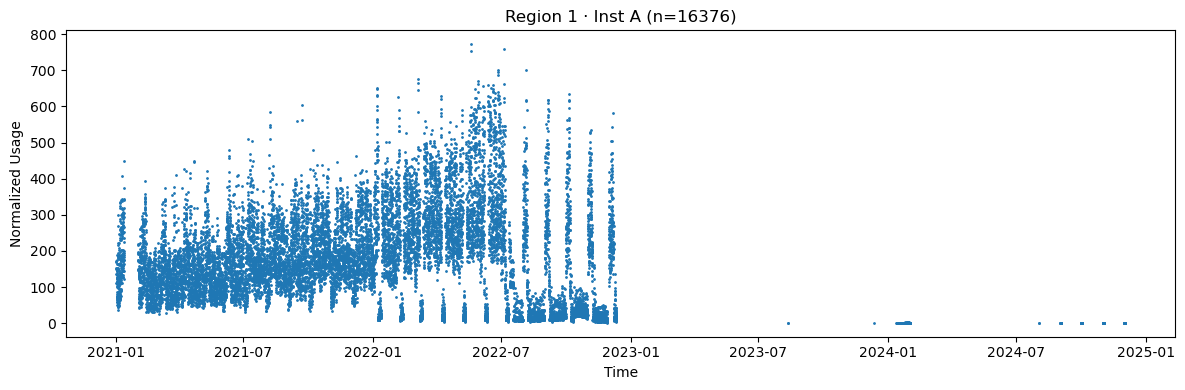

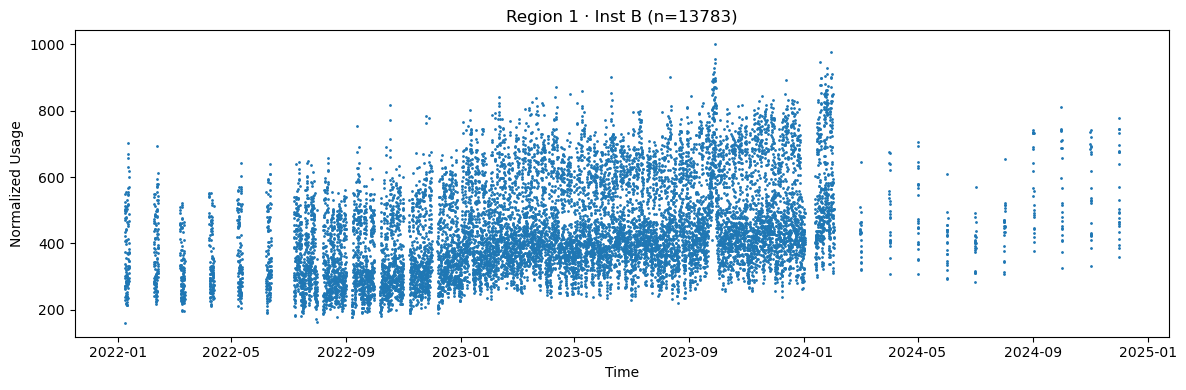

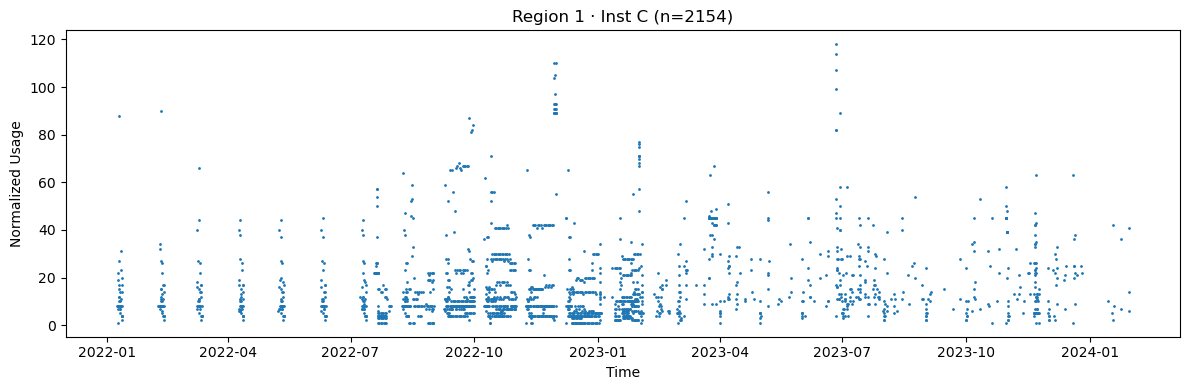

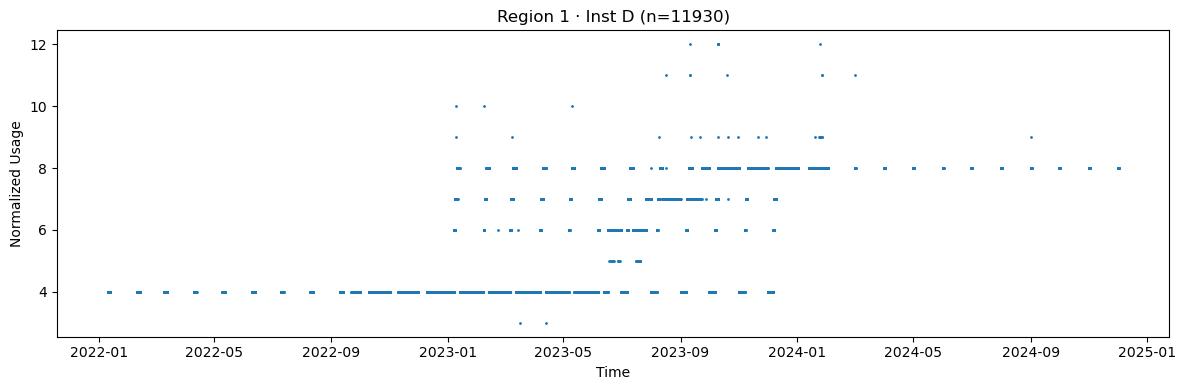

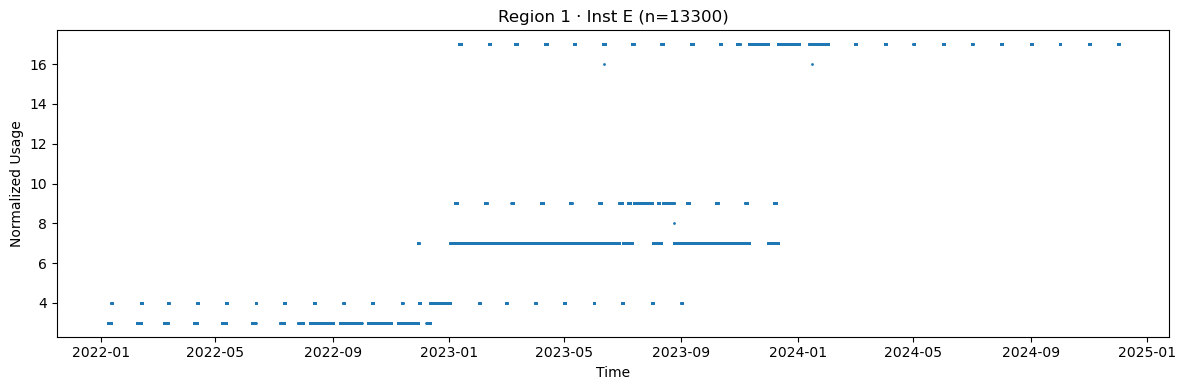

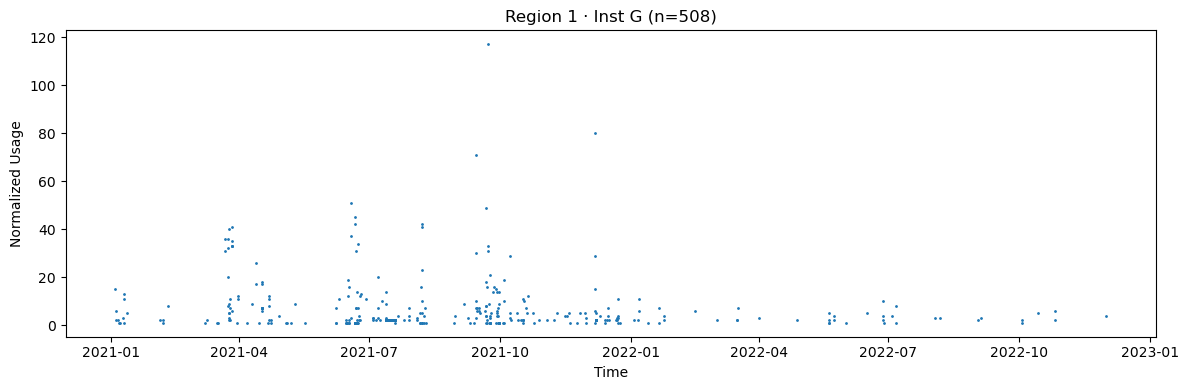

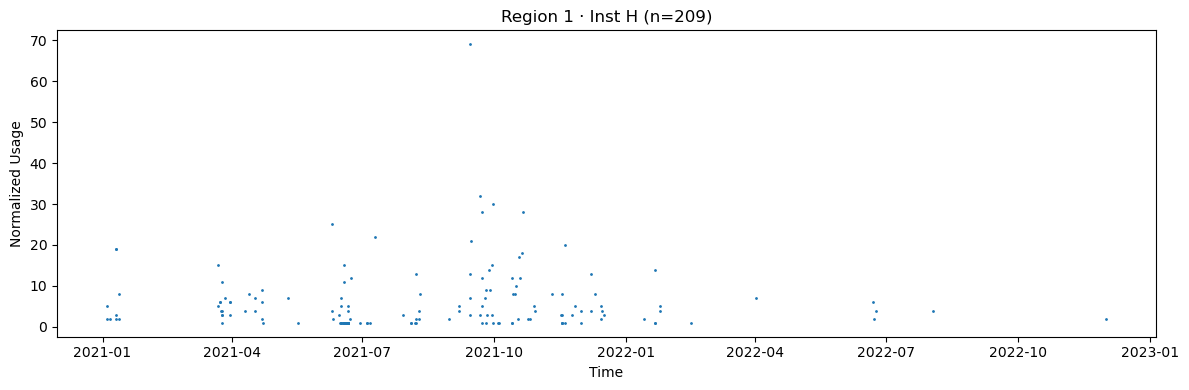

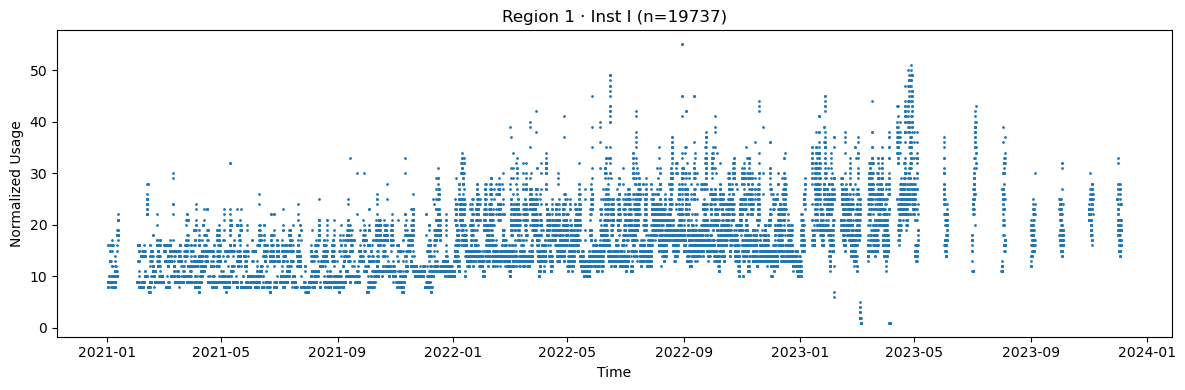

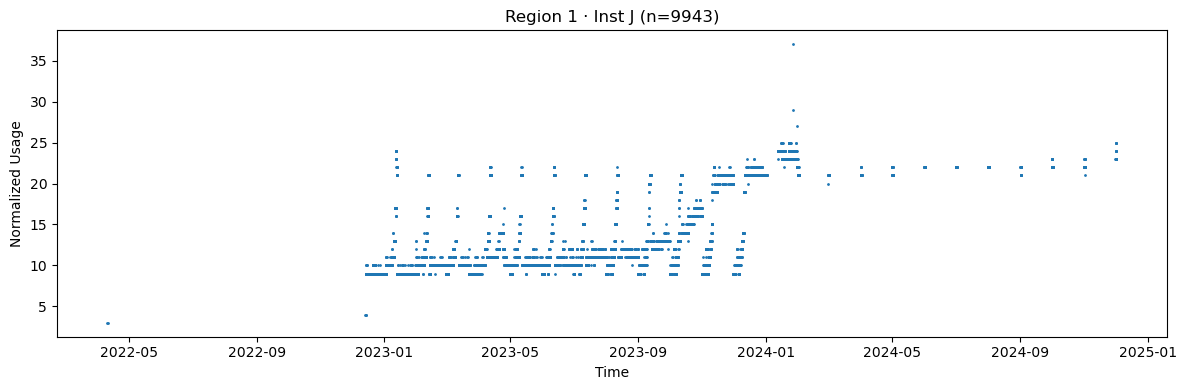

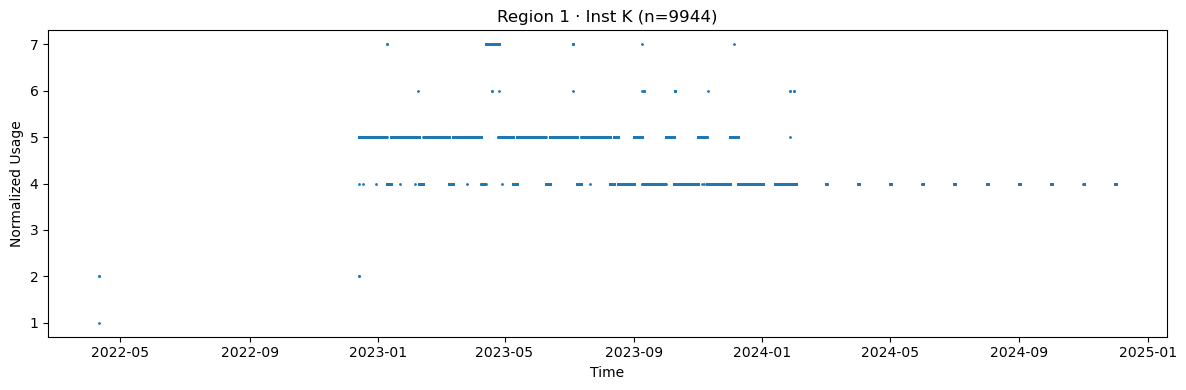

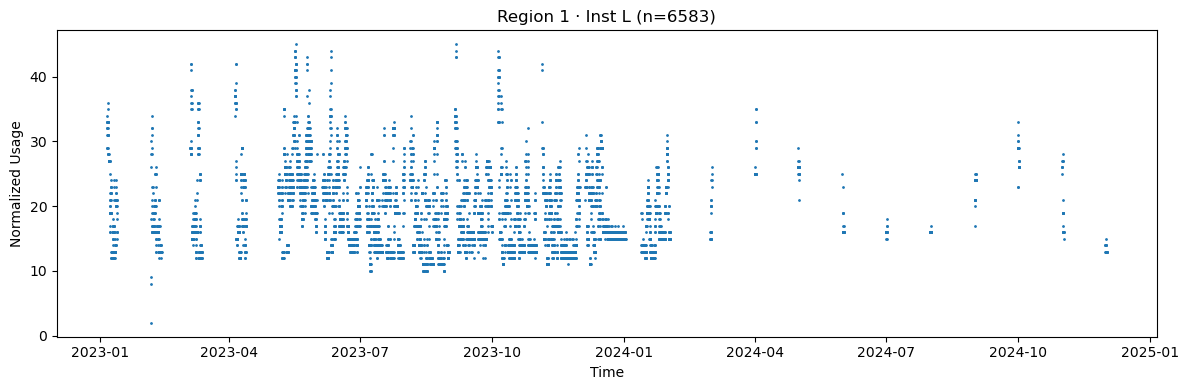

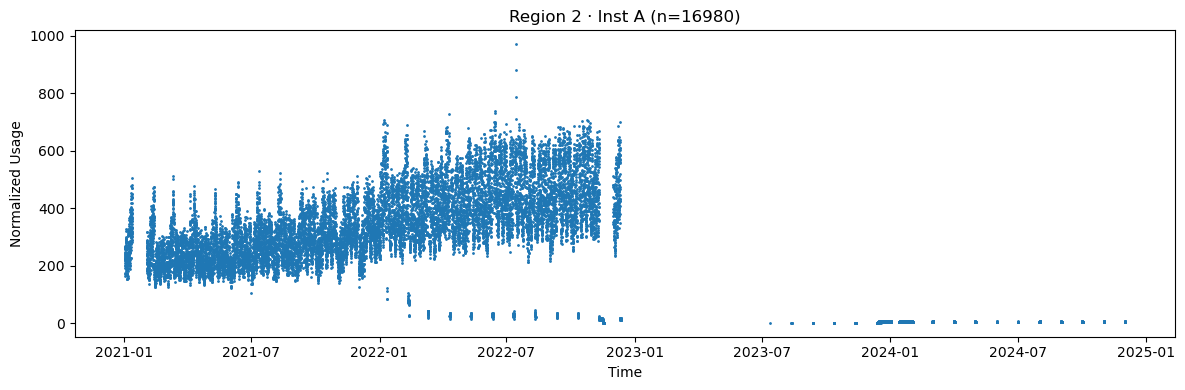

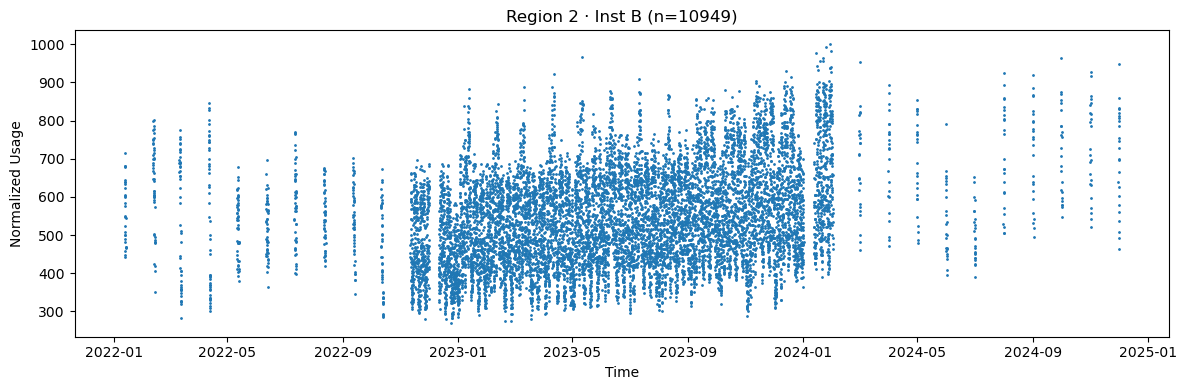

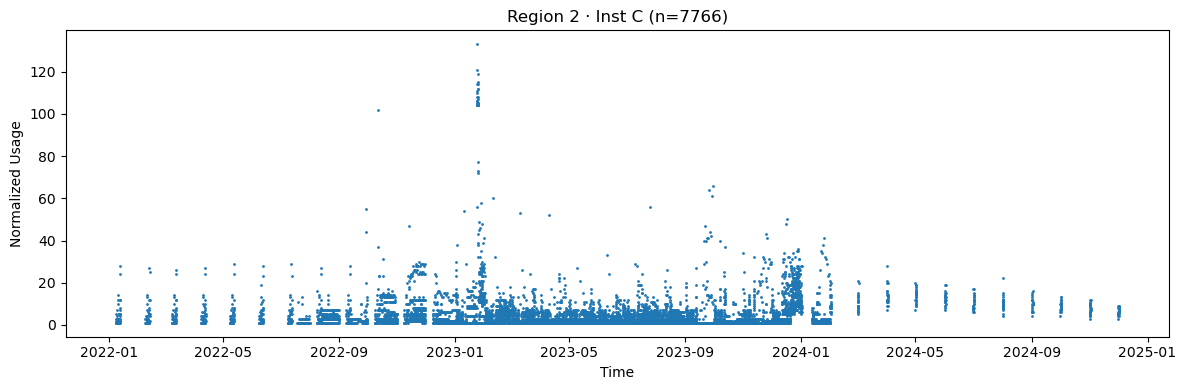

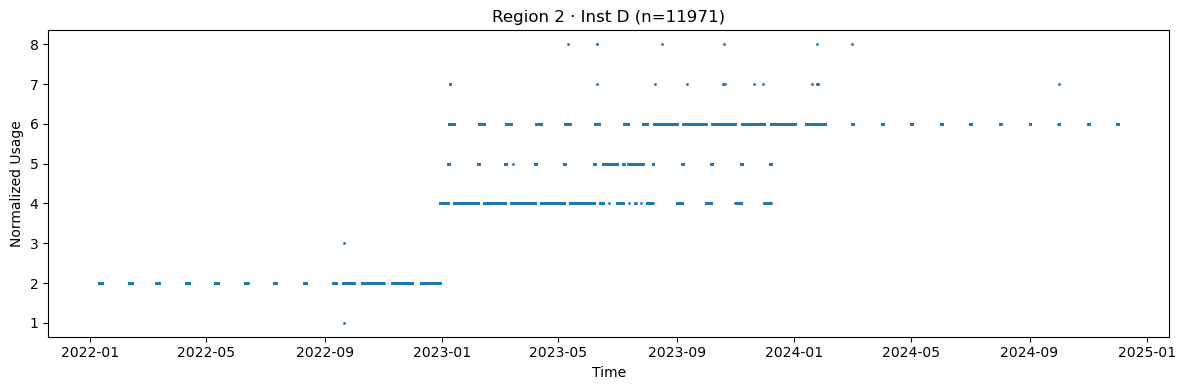

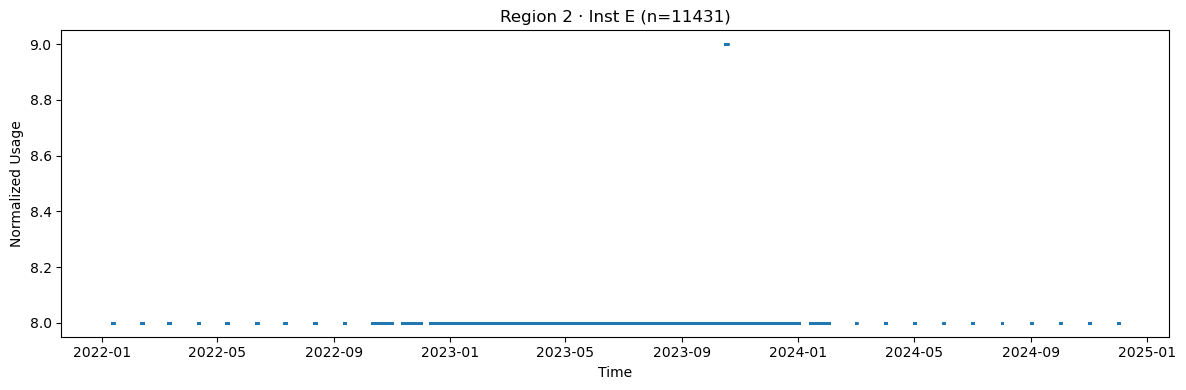

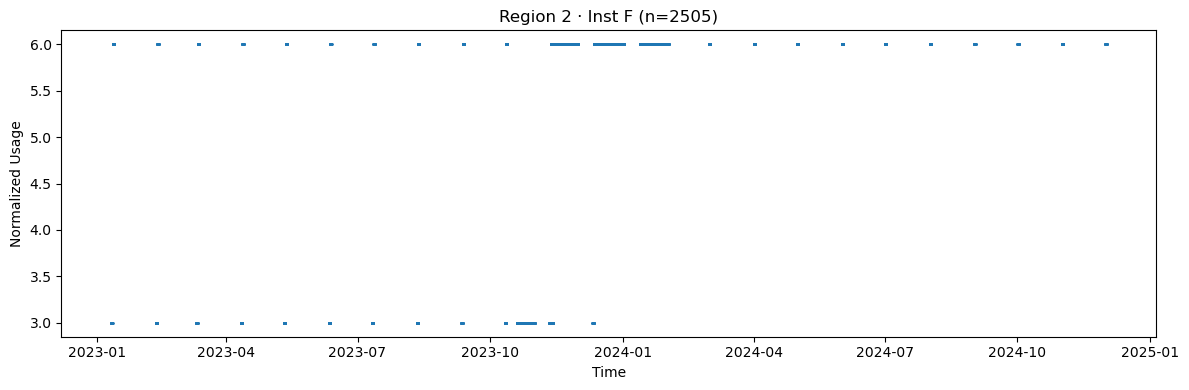

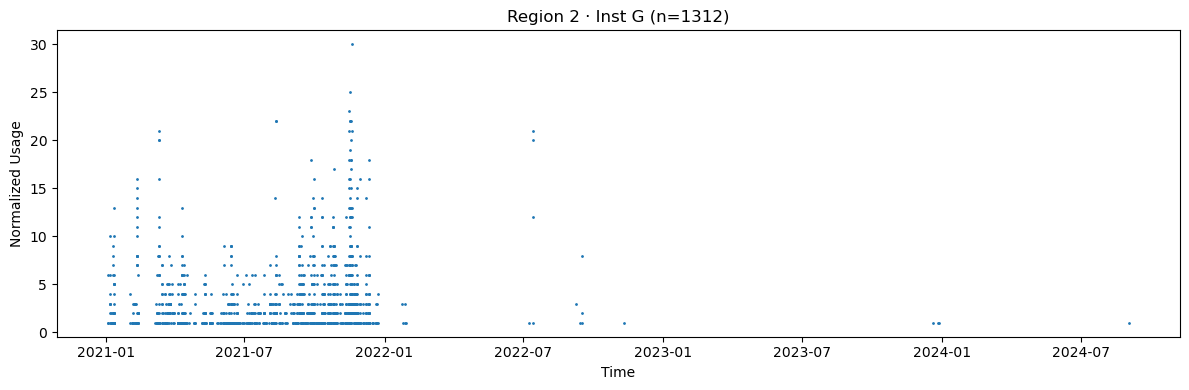

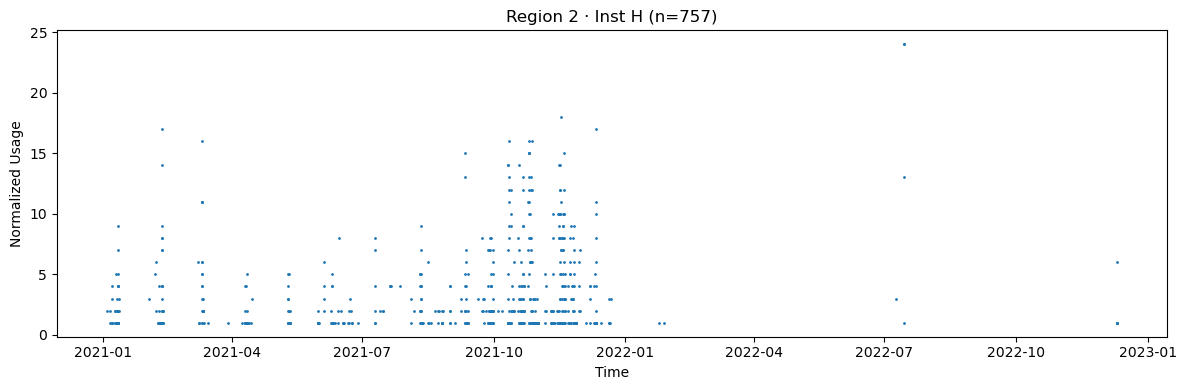

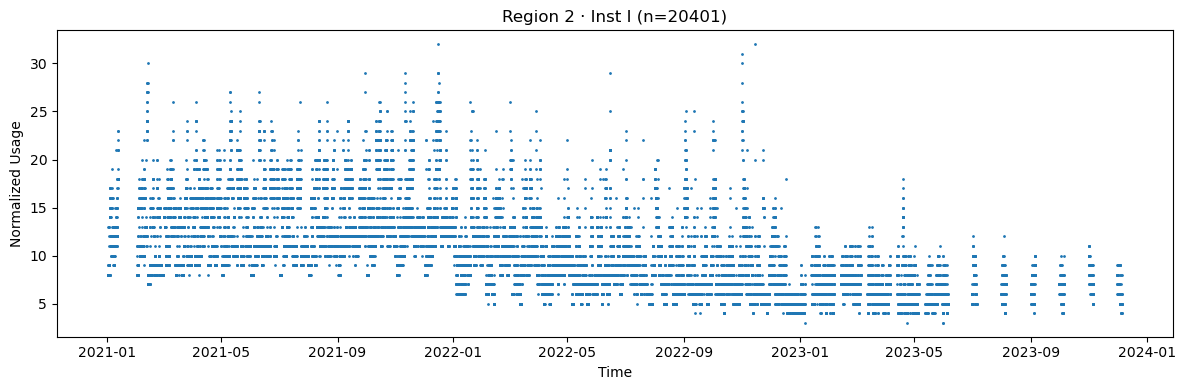

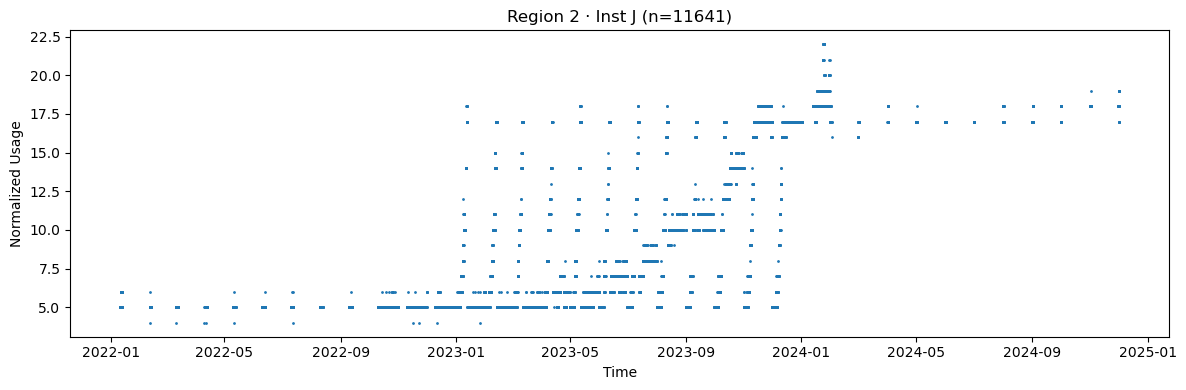

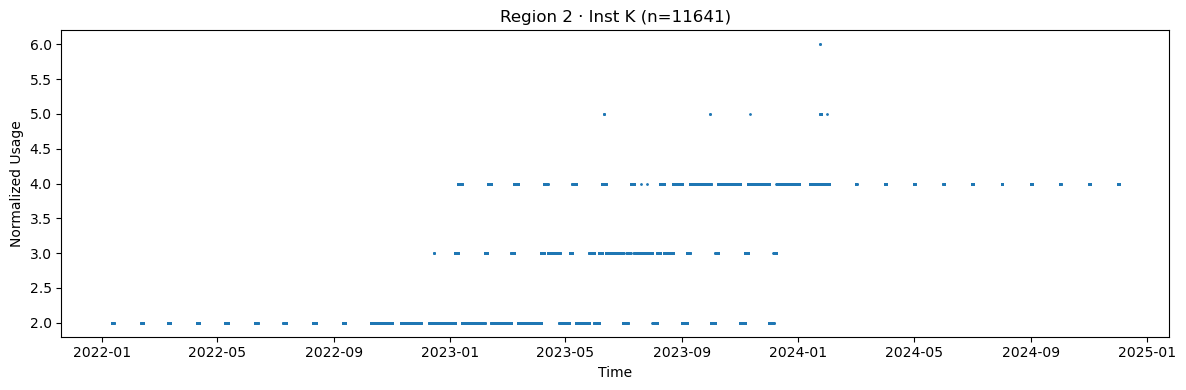

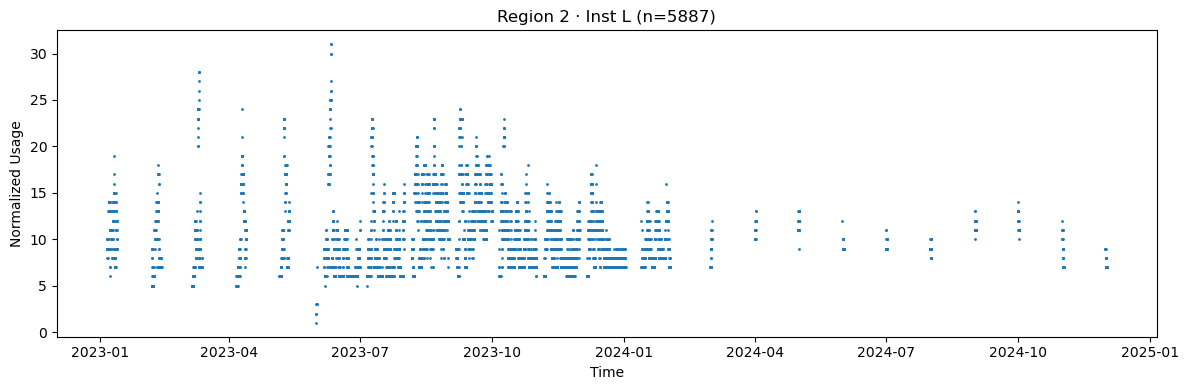

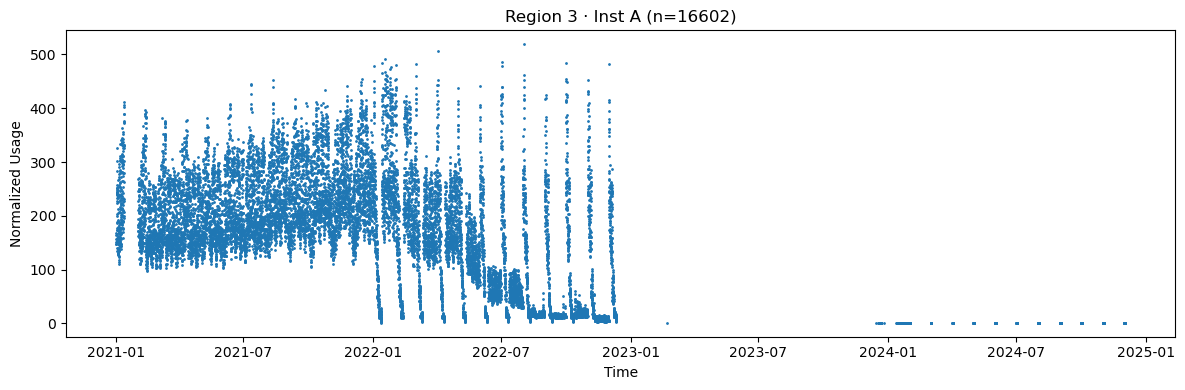

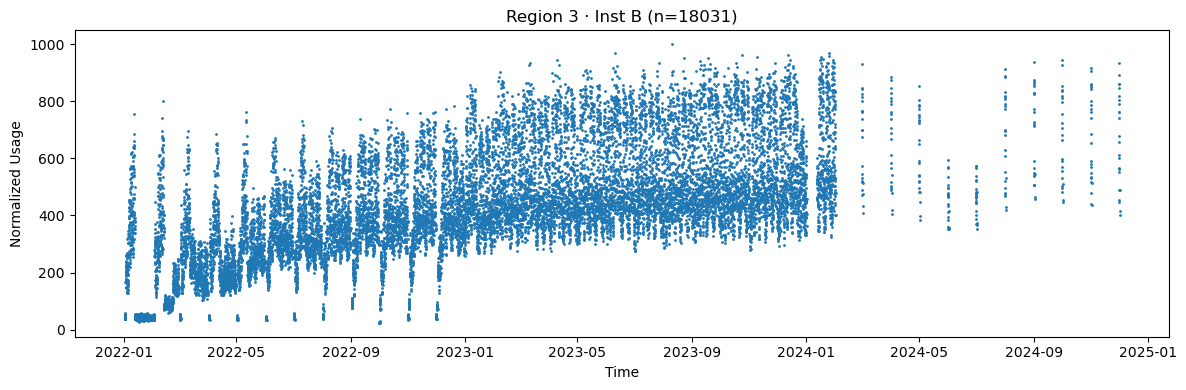

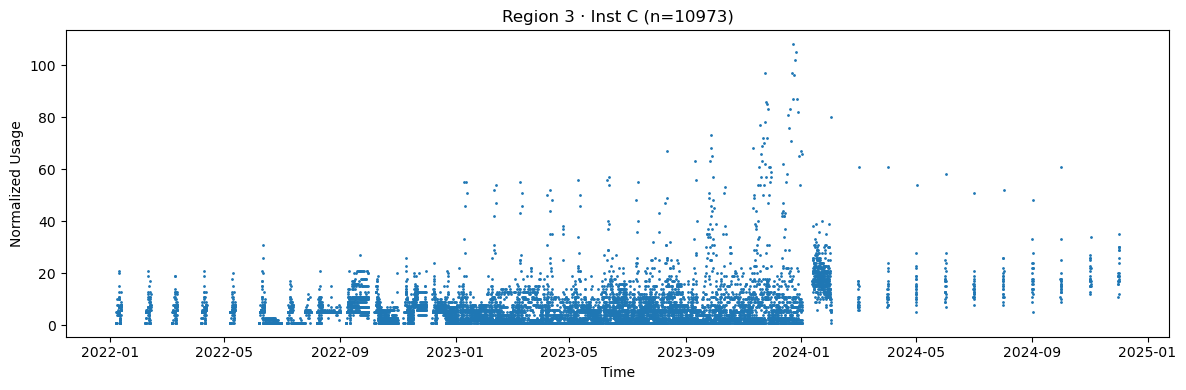

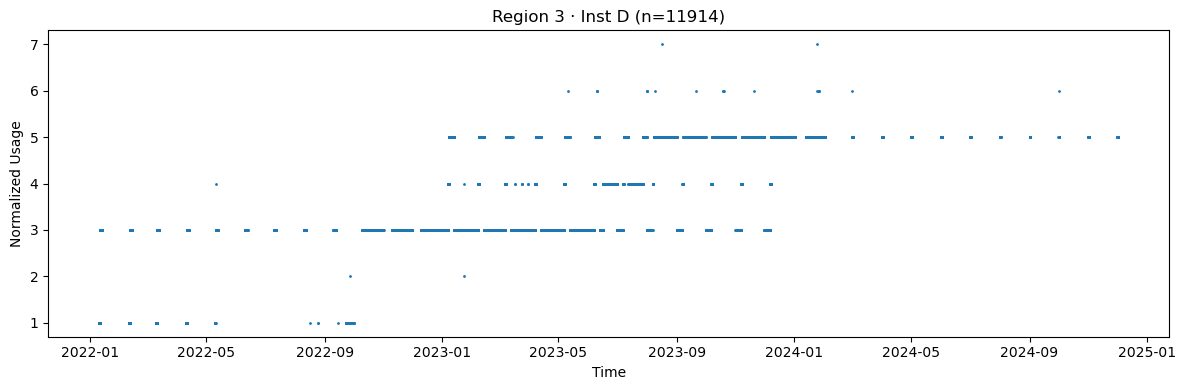

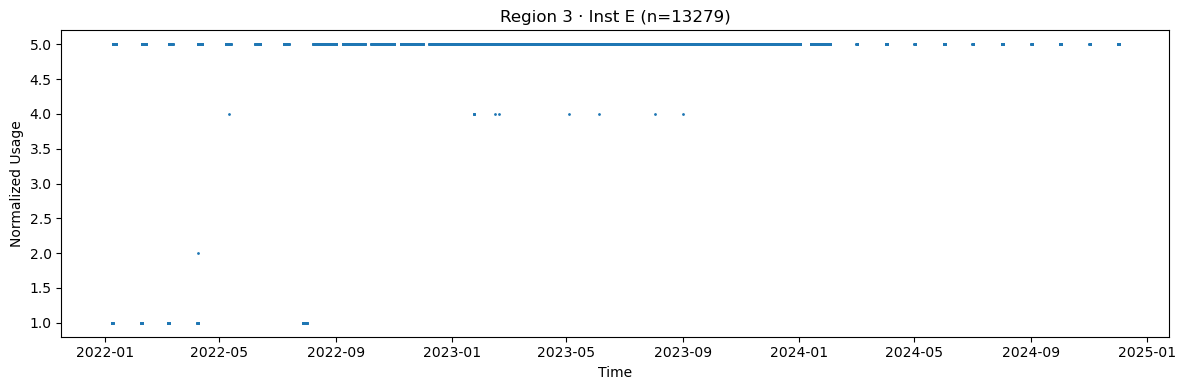

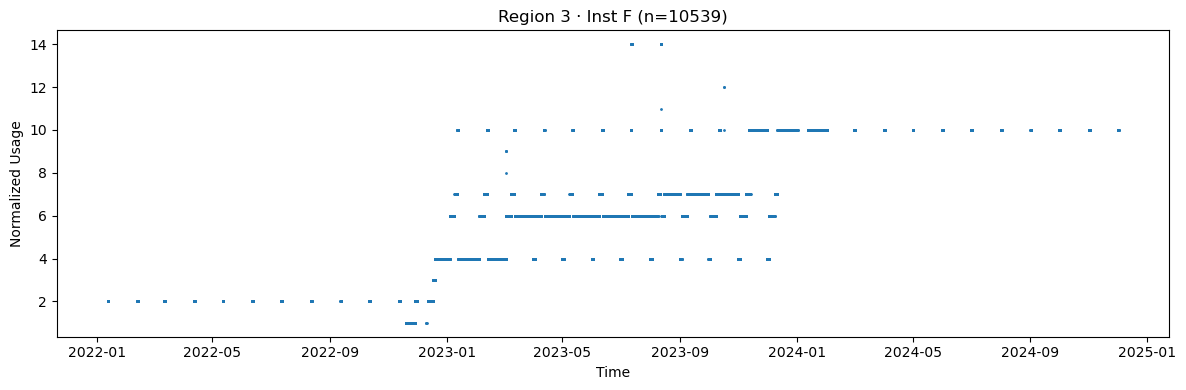

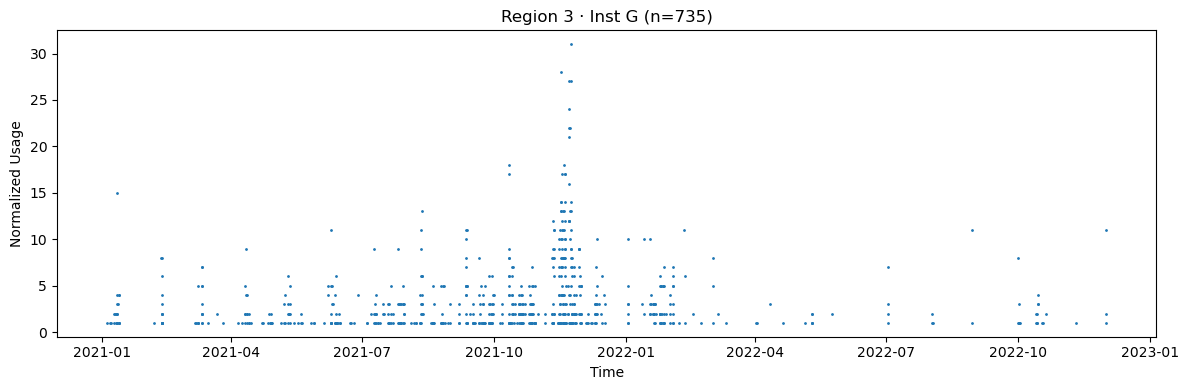

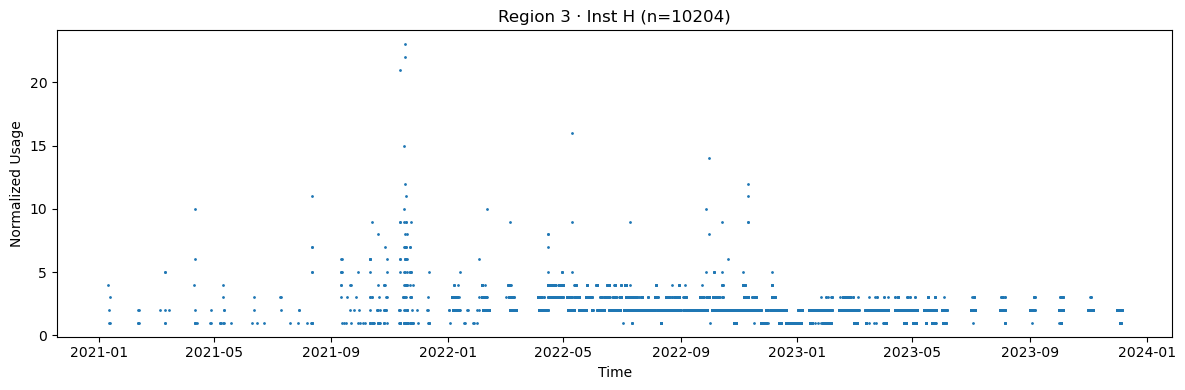

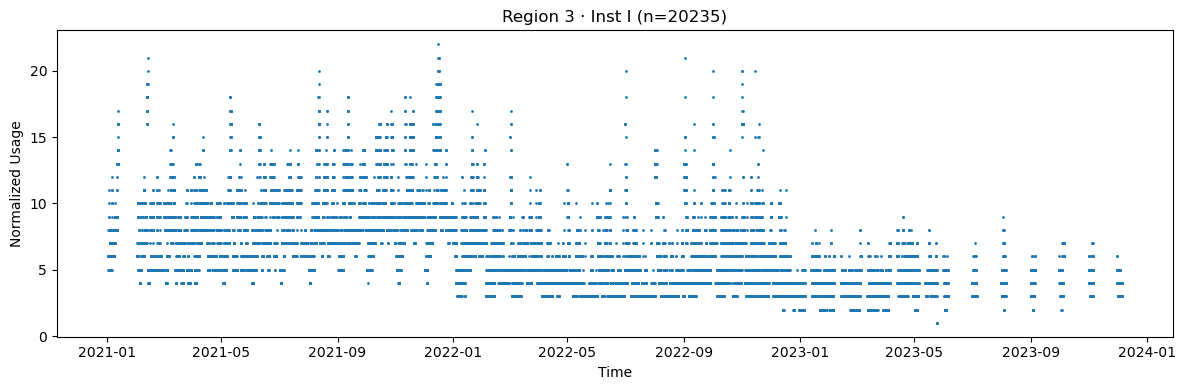

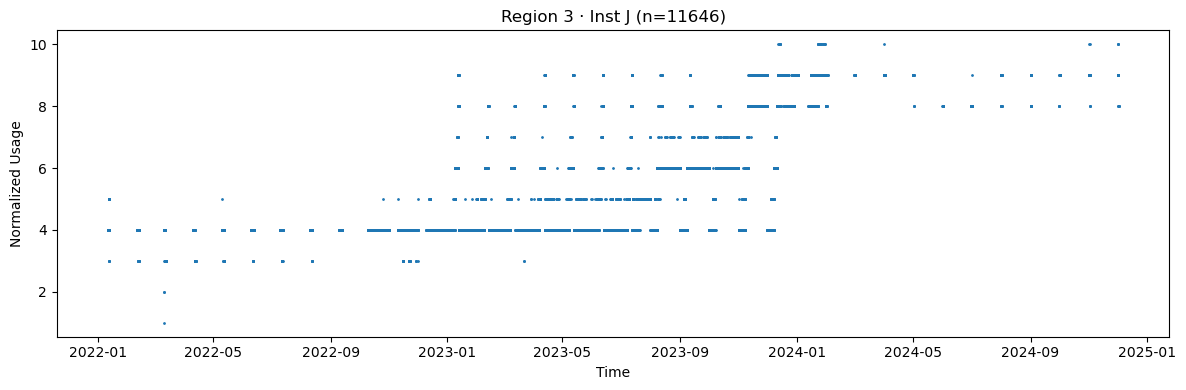

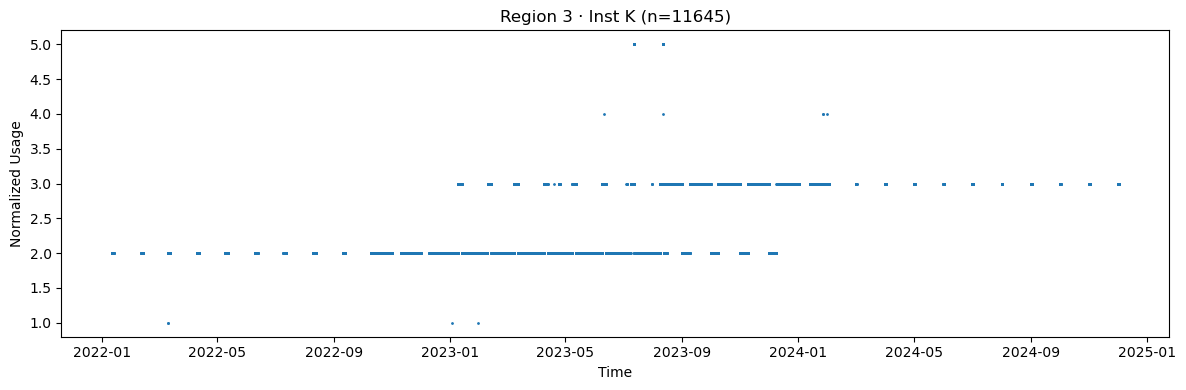

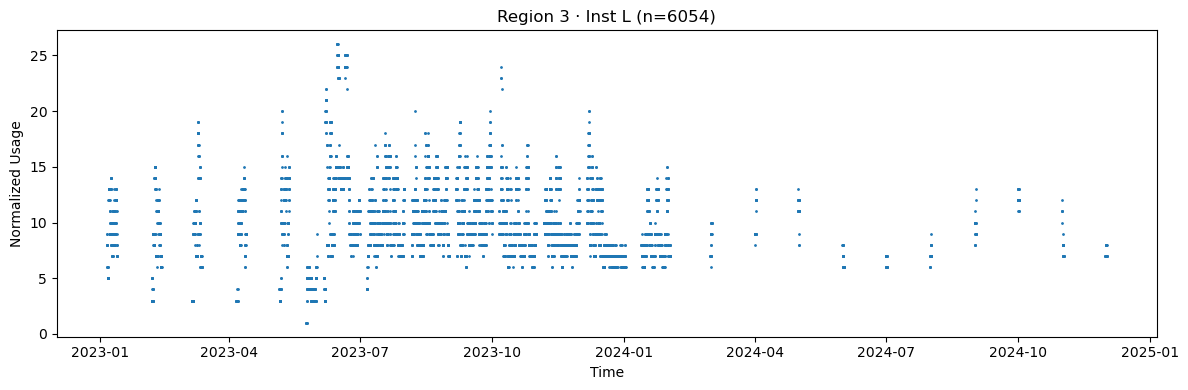

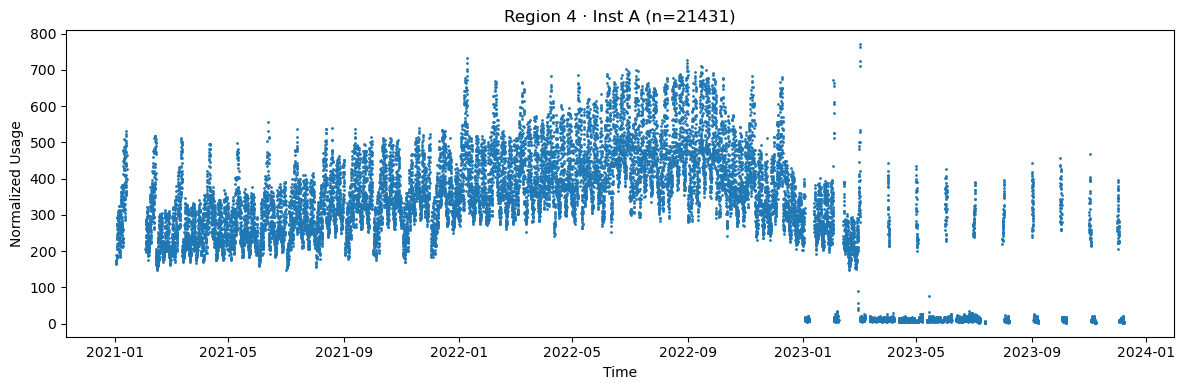

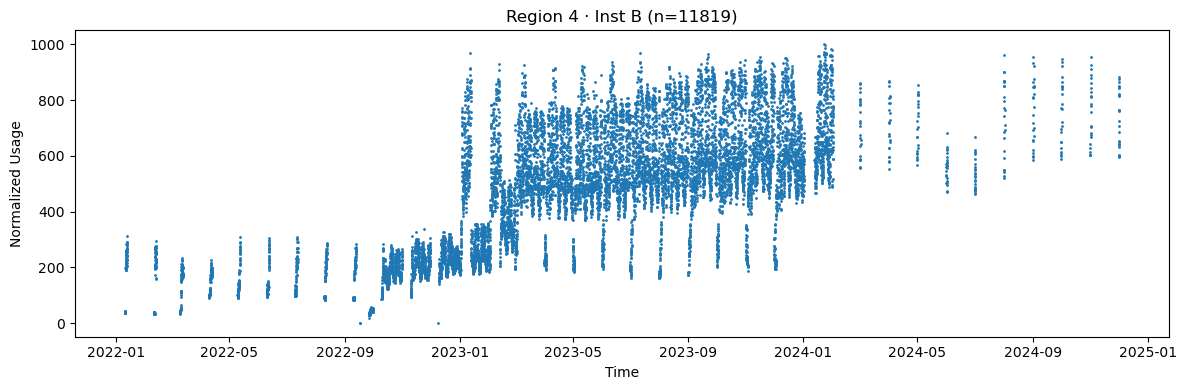

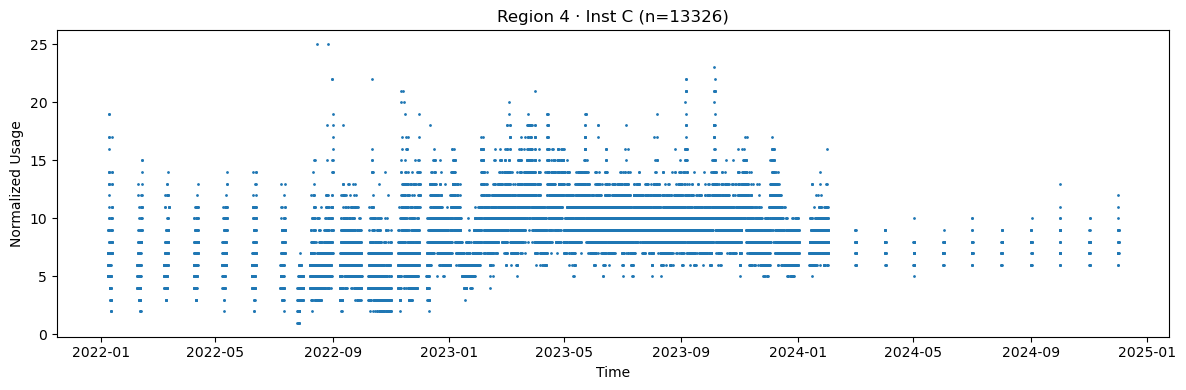

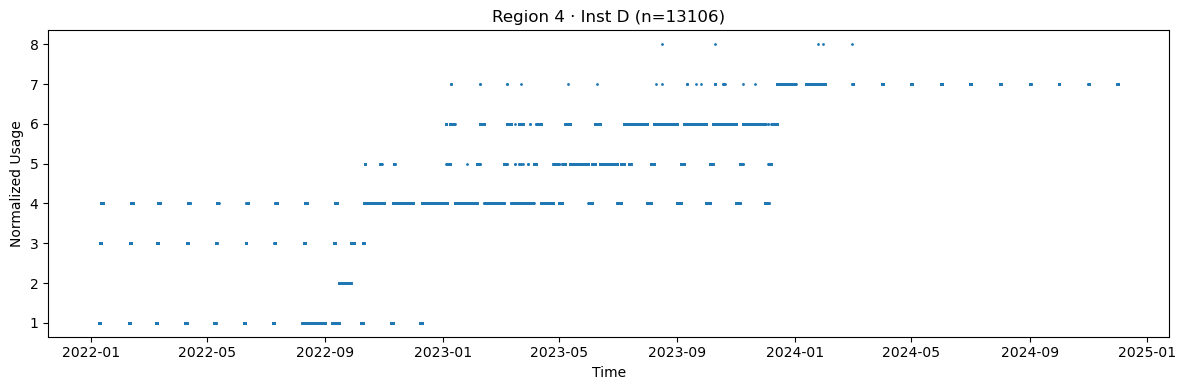

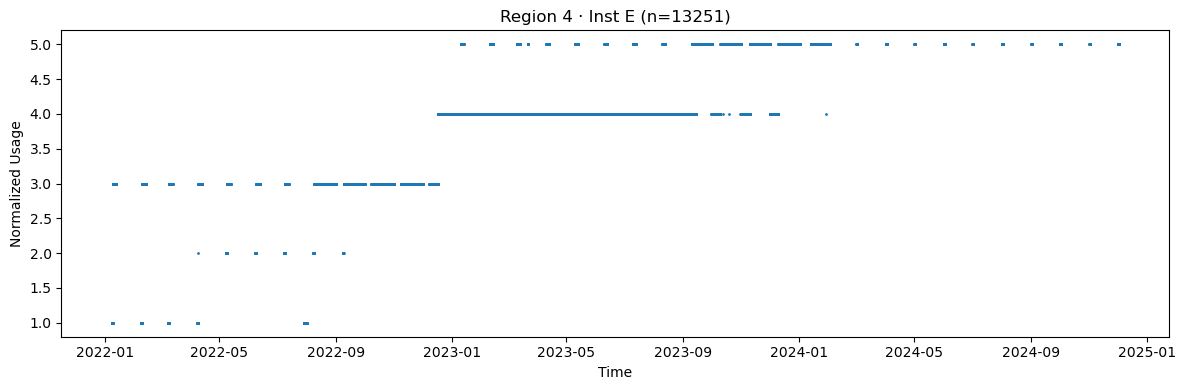

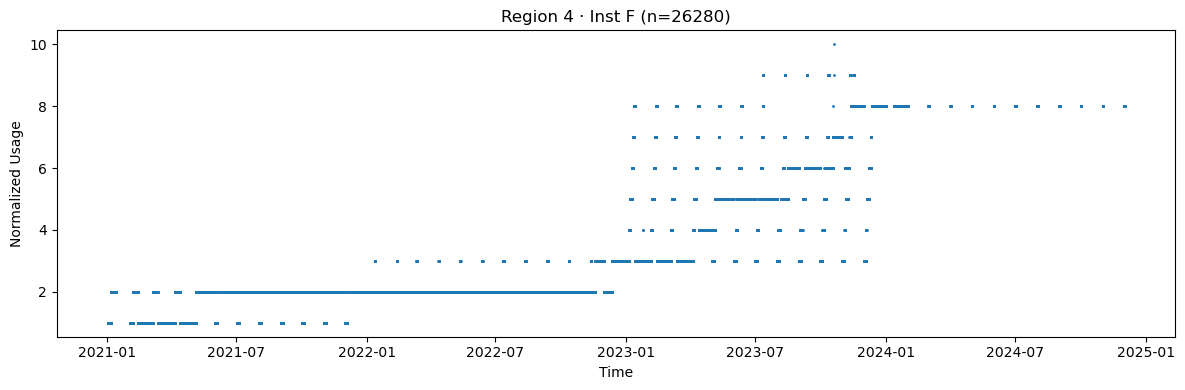

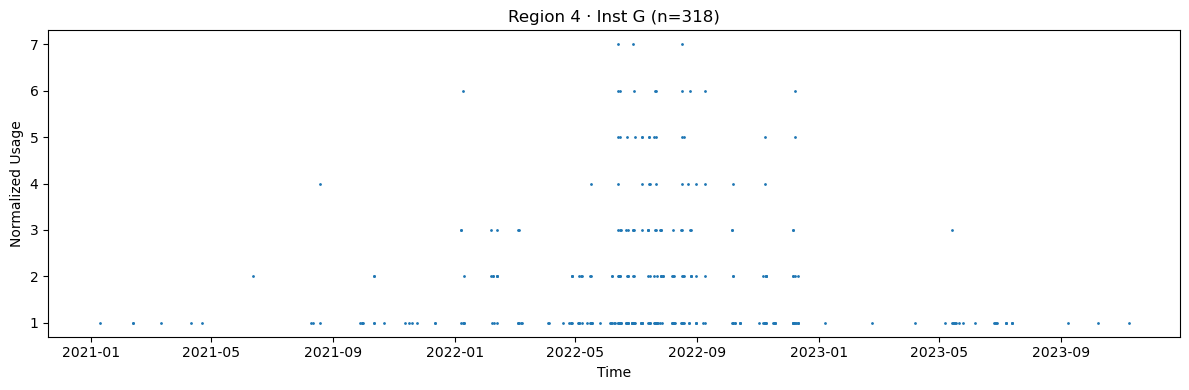

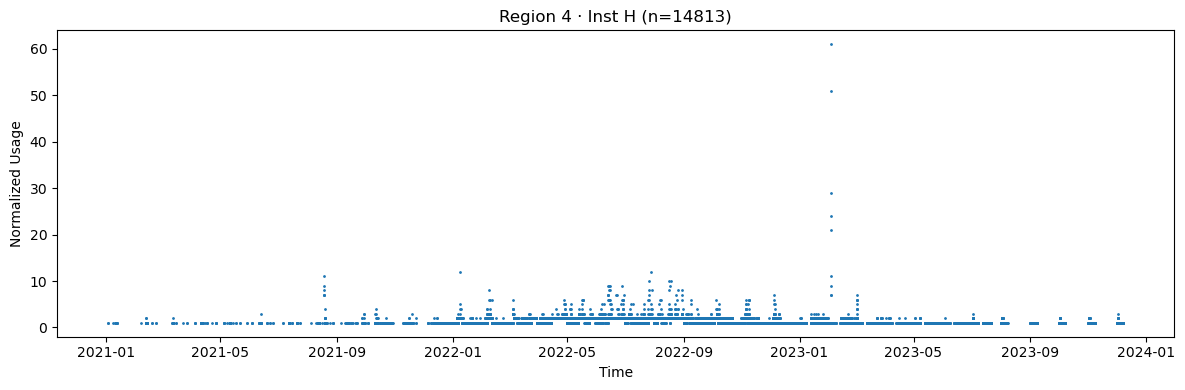

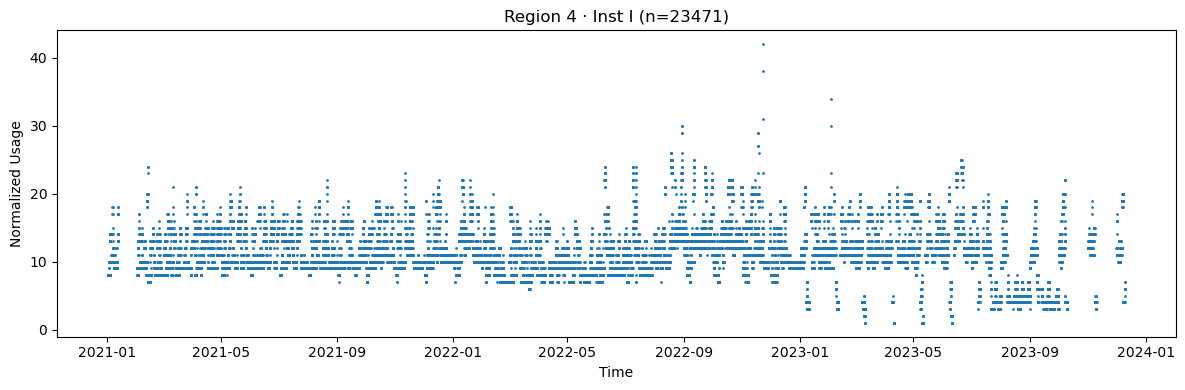

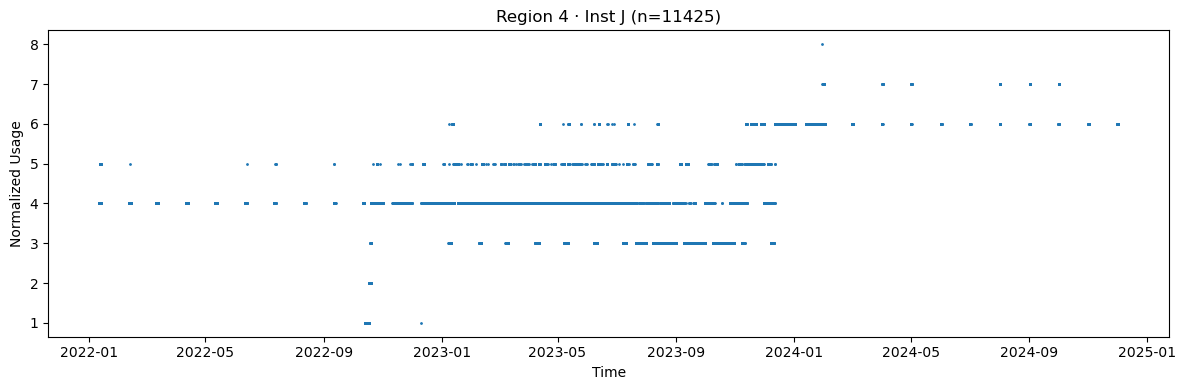

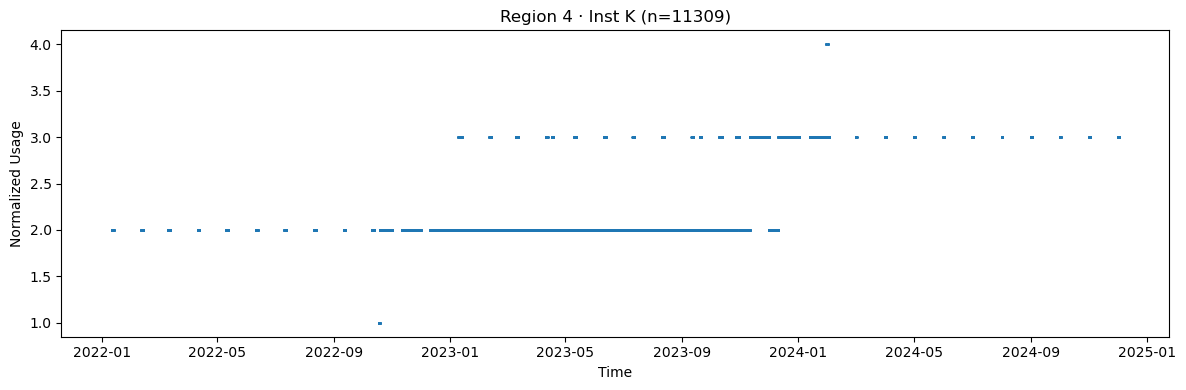

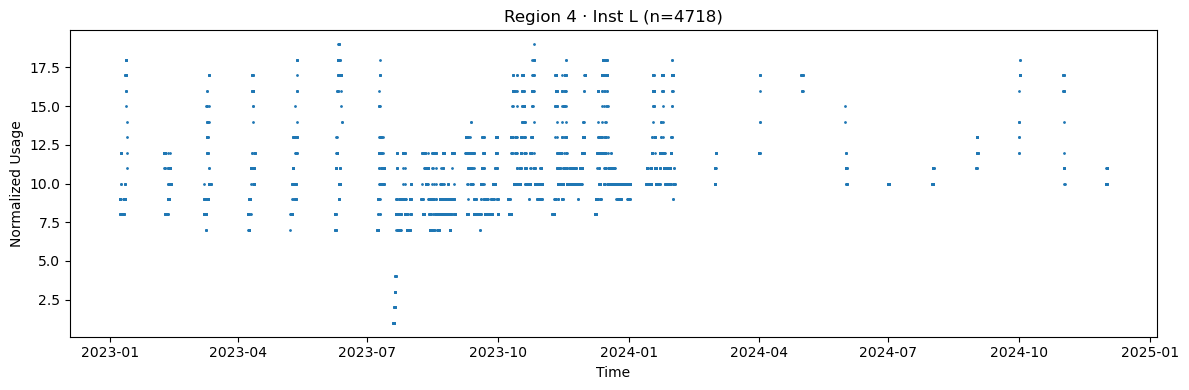

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load raw
df = pd.read_csv("hourly_normalized.csv")

# 2. Strip off any “.000” millisecond suffix
df["raw_ts"] = df["USAGE_HOUR"].str.strip().str.replace(r"\.000$", "", regex=True)

# 3. First pass: day-first (dd-mm-YYYY H:M[:S])
ts1 = pd.to_datetime(
    df["raw_ts"],
    dayfirst=True,
    infer_datetime_format=True,
    errors="coerce"
)

# 4. Second pass: for all where that failed, infer ISO
mask = ts1.isna()
if mask.any():
    ts2 = pd.to_datetime(
        df.loc[mask, "raw_ts"],
        infer_datetime_format=True,
        errors="raise"     # you want it to blow up if really unparseable
    )
    ts1.loc[mask] = ts2

# 5. Assign back & drop temp
df["USAGE_HOUR"] = ts1
df.drop(columns=["raw_ts"], inplace=True)

# 6. Sort
df.sort_values("USAGE_HOUR", inplace=True)

# 7. Count records per combination
counts = (
    df
    .groupby(["REGION_NUM","INSTANCE_TYPE"])
    .size()
    .reset_index(name="record_count")
)
print(counts)

# 8. Plot each time series
for (rg, inst), grp in df.groupby(["REGION_NUM","INSTANCE_TYPE"]):
    plt.figure(figsize=(12,4))
    plt.plot(grp["USAGE_HOUR"], grp["NORM_USAGE"], ".", ms=2)
    plt.title(f"Region {rg} · Inst {inst} (n={len(grp)})")
    plt.xlabel("Time")
    plt.ylabel("Normalized Usage")
    plt.tight_layout()
    plt.show()


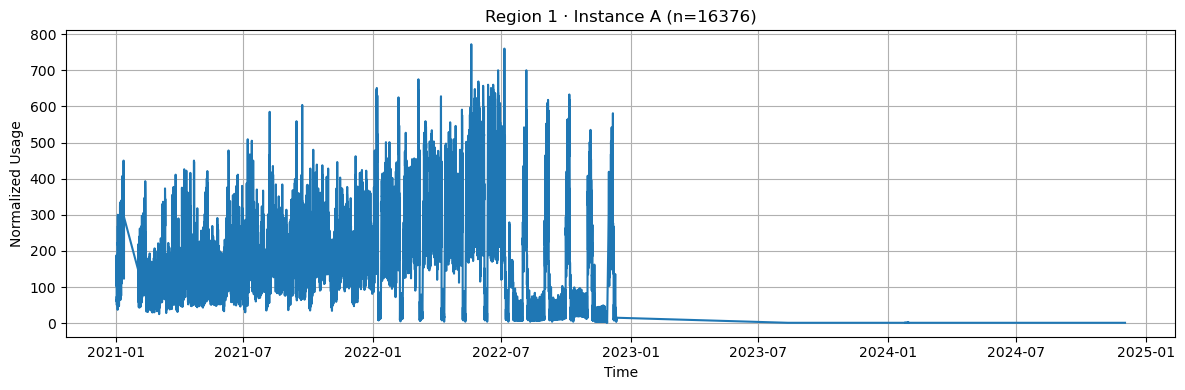

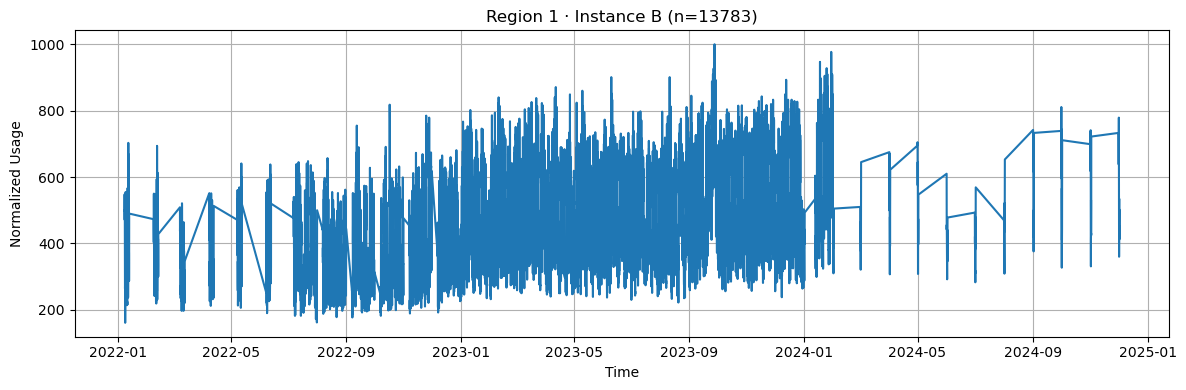

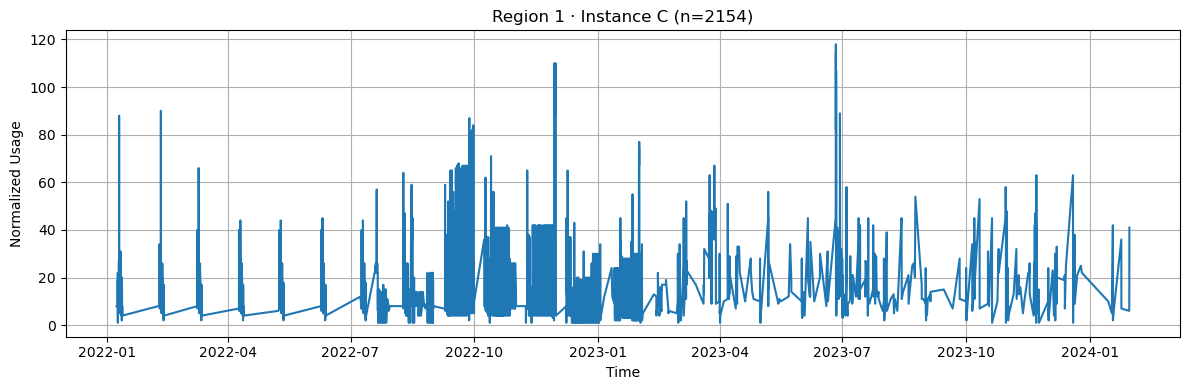

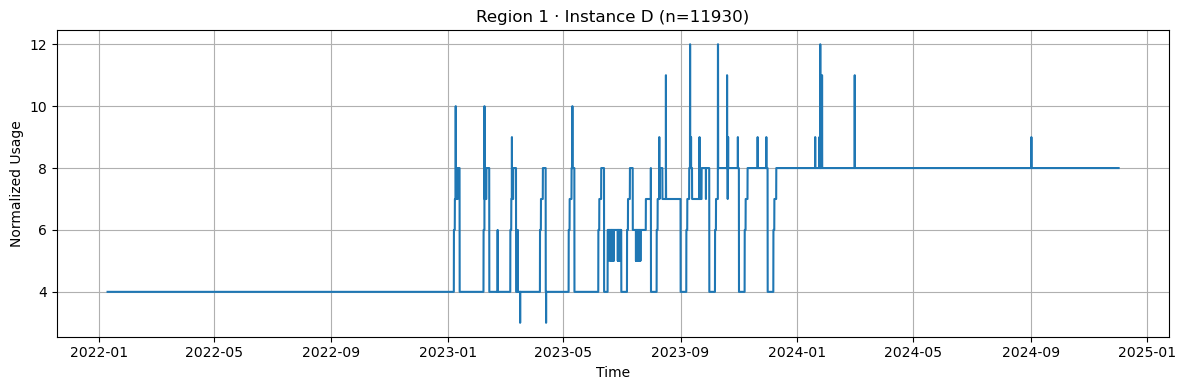

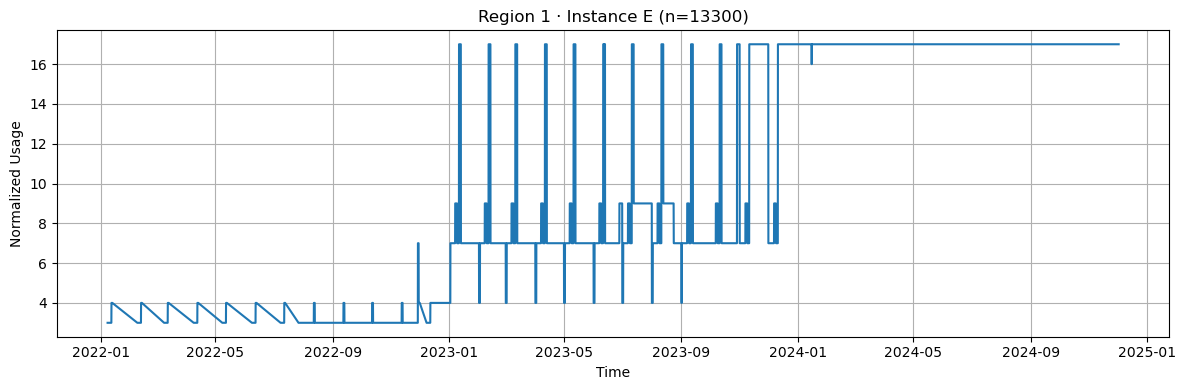

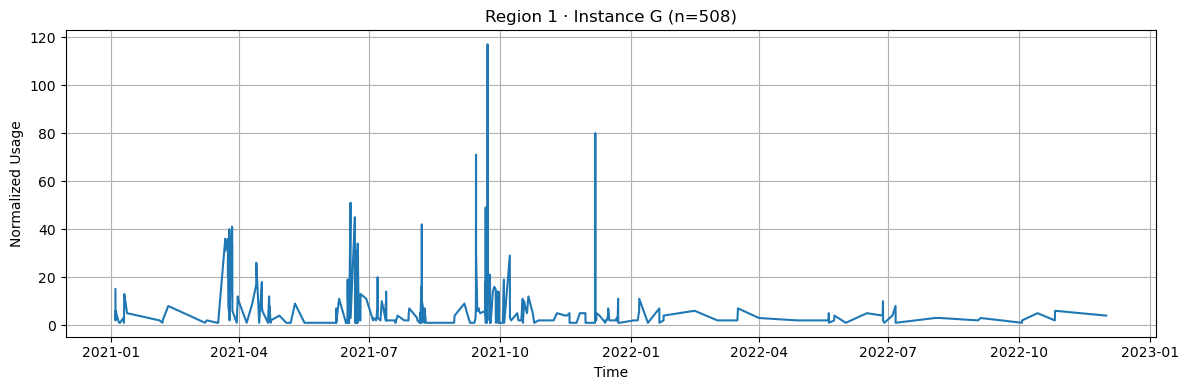

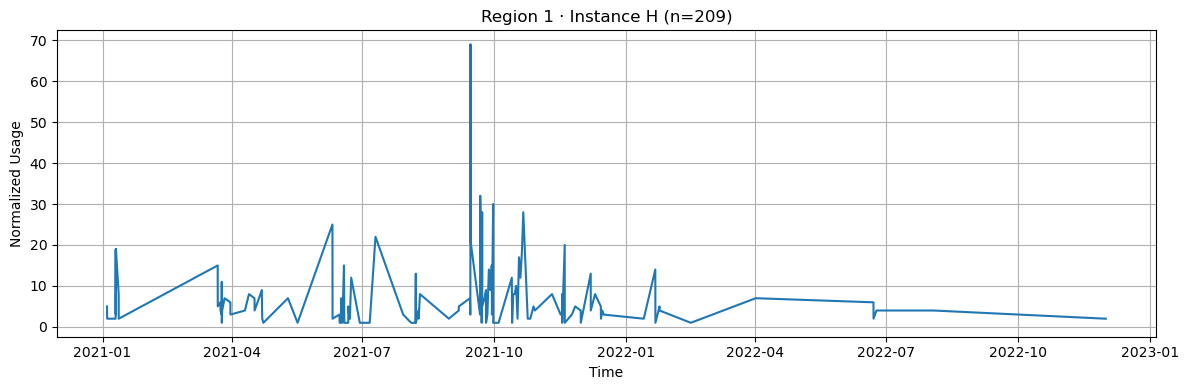

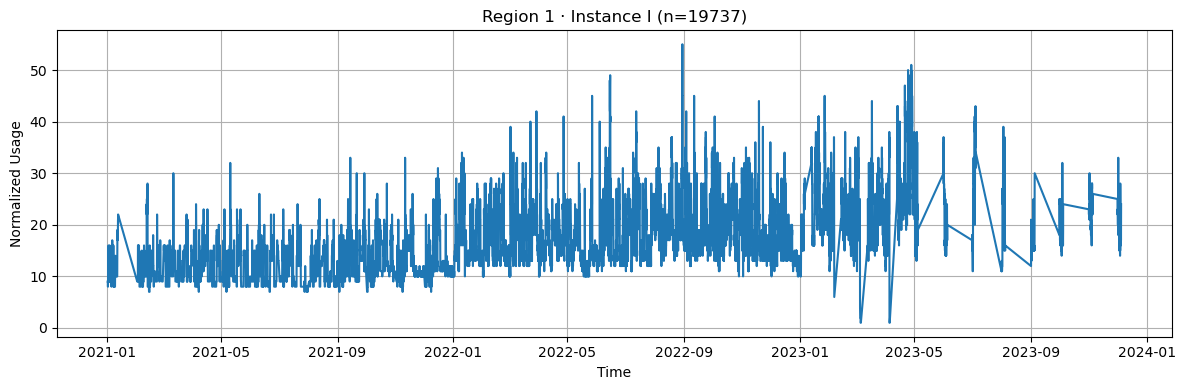

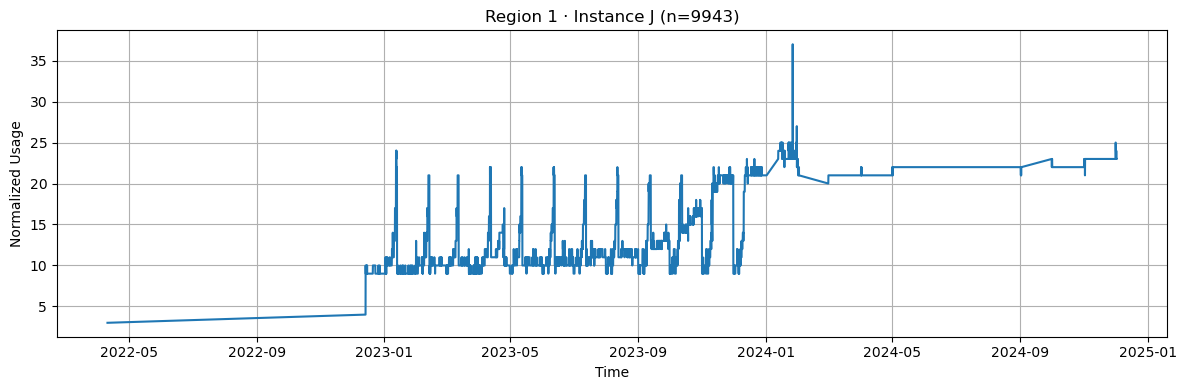

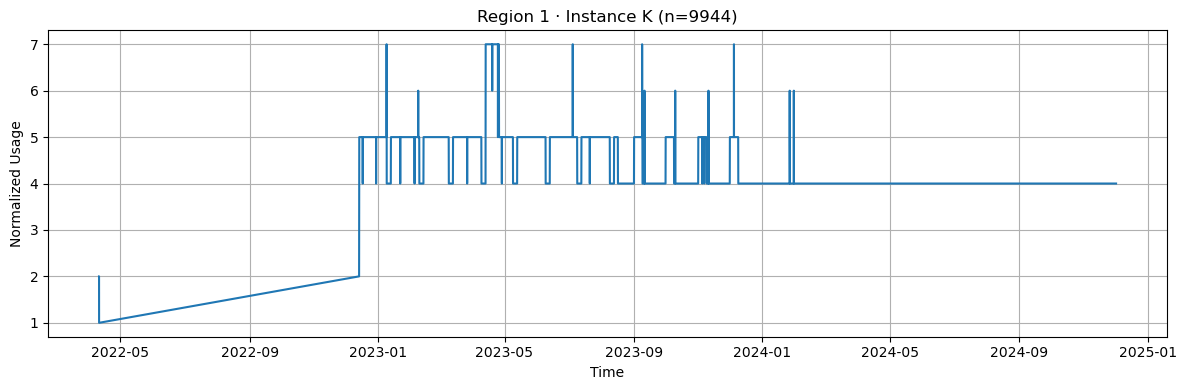

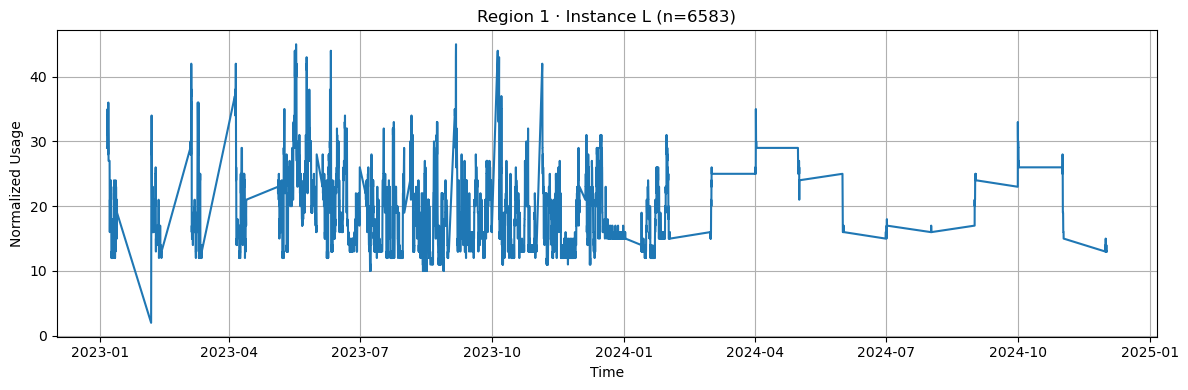

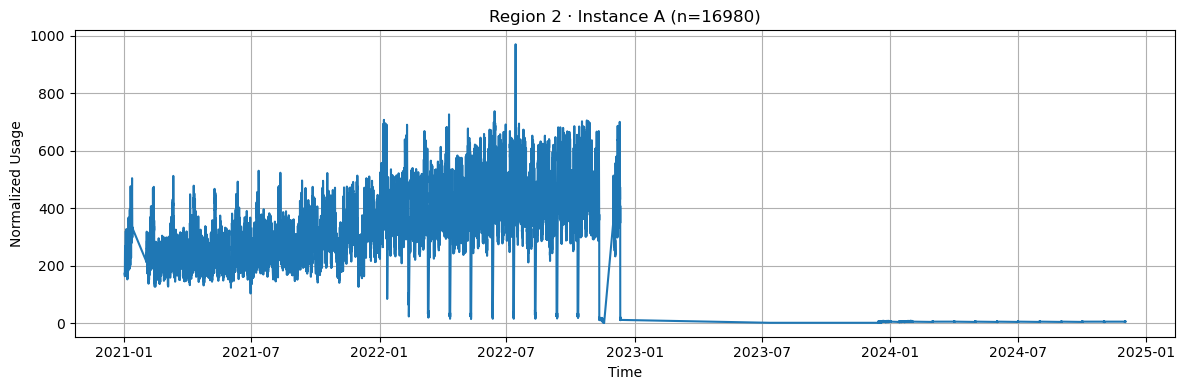

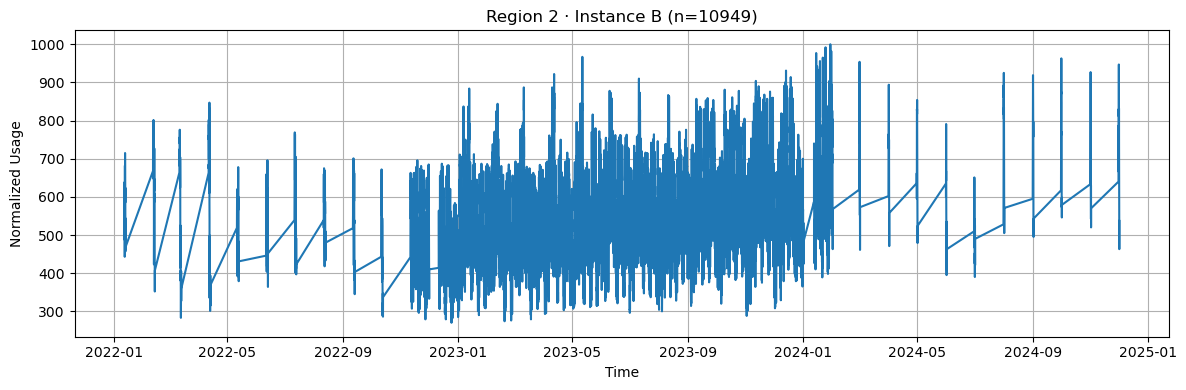

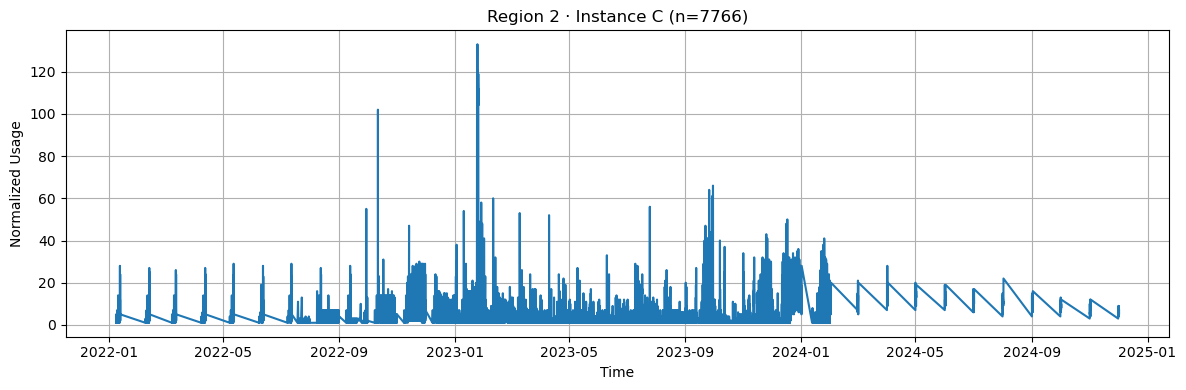

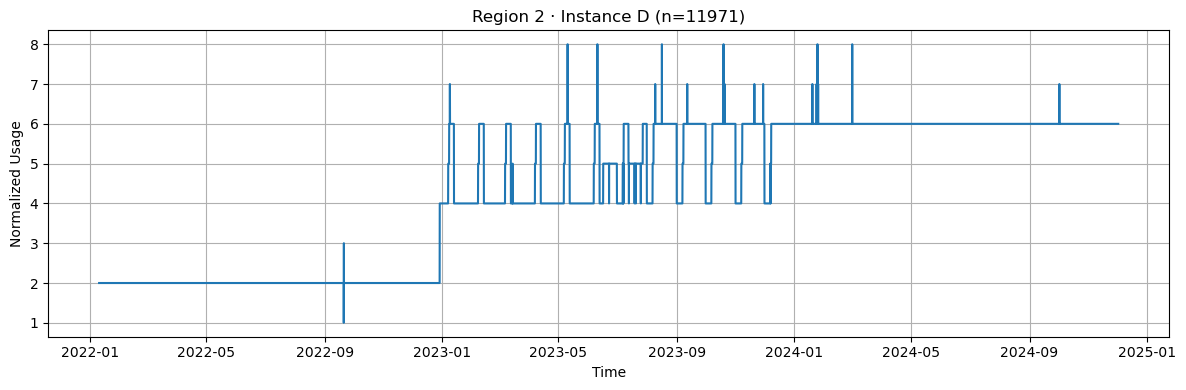

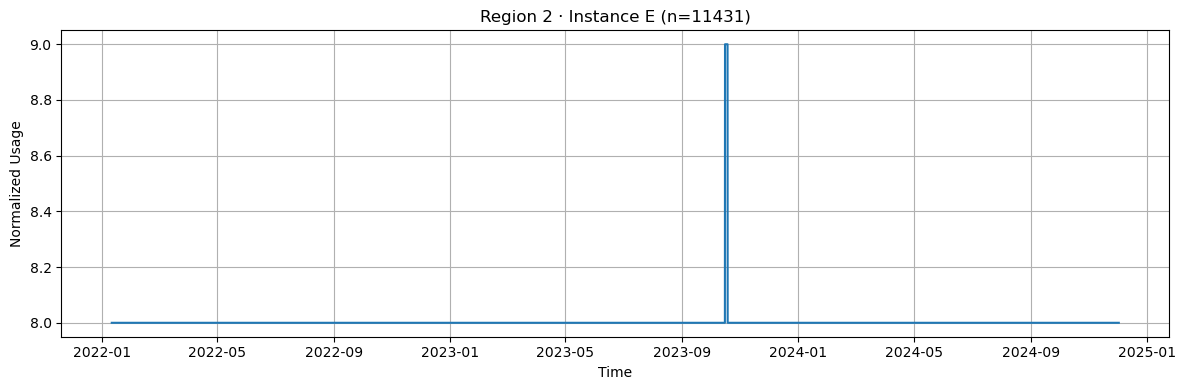

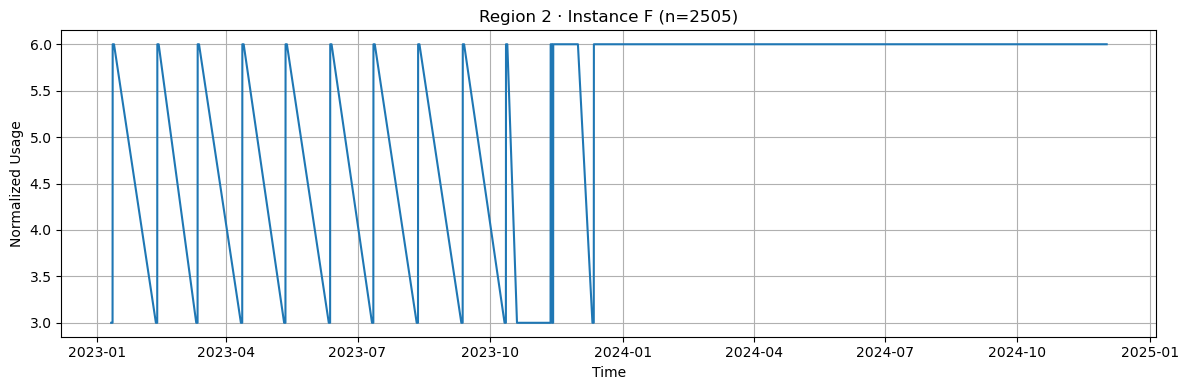

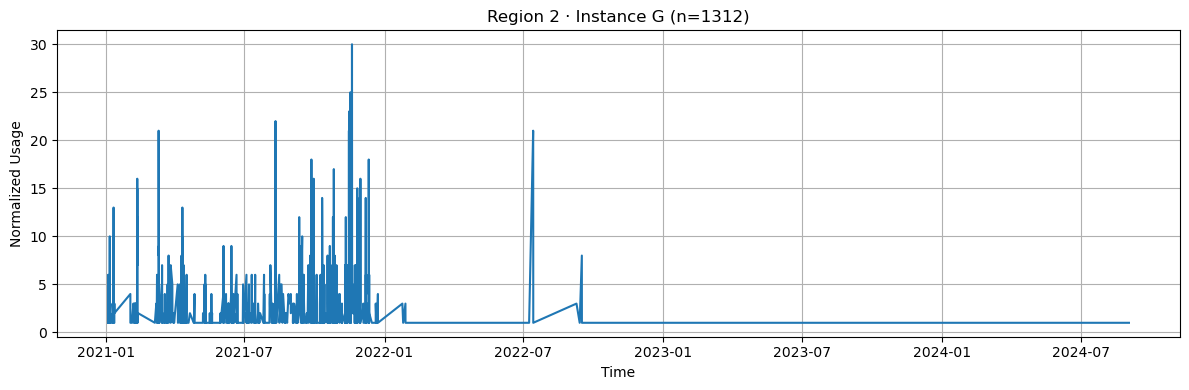

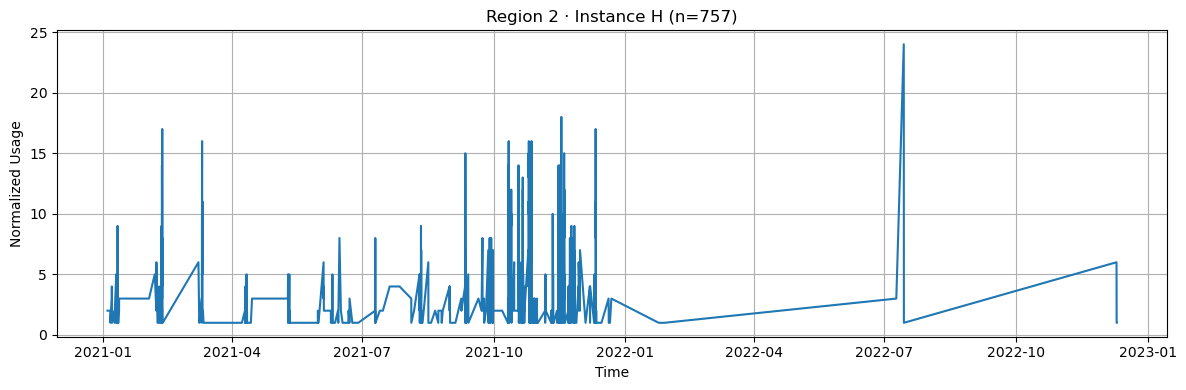

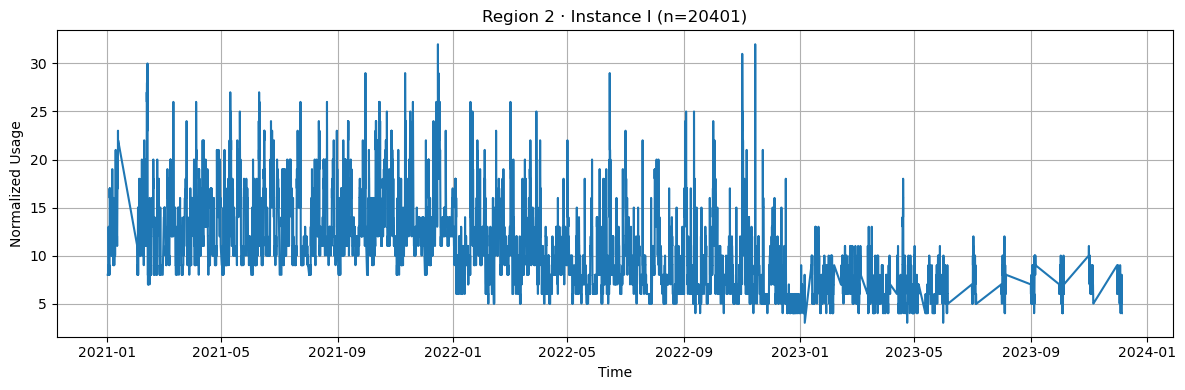

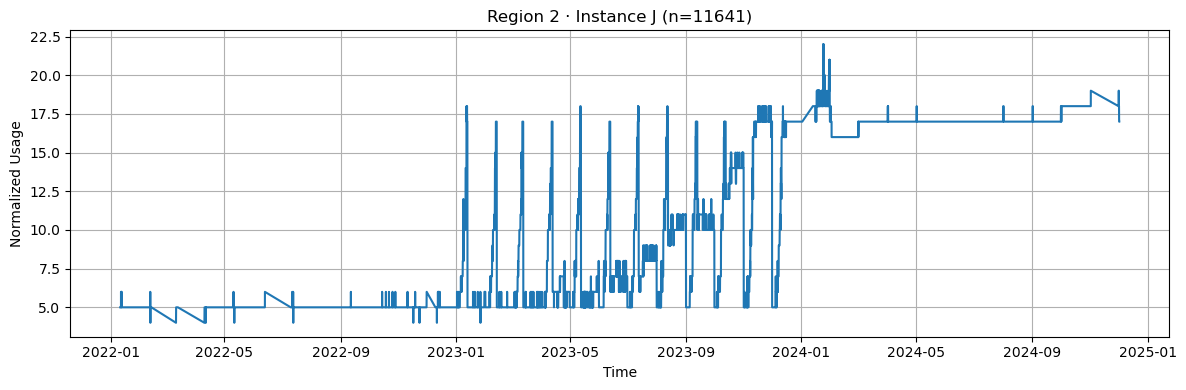

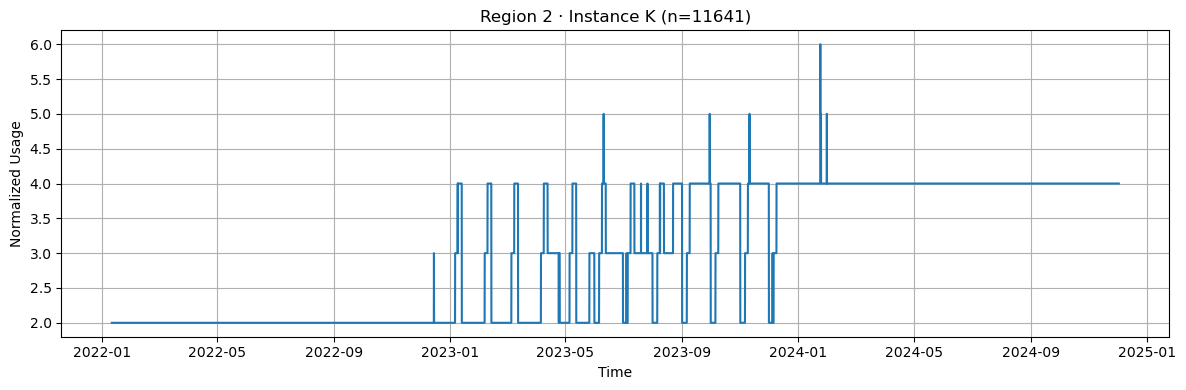

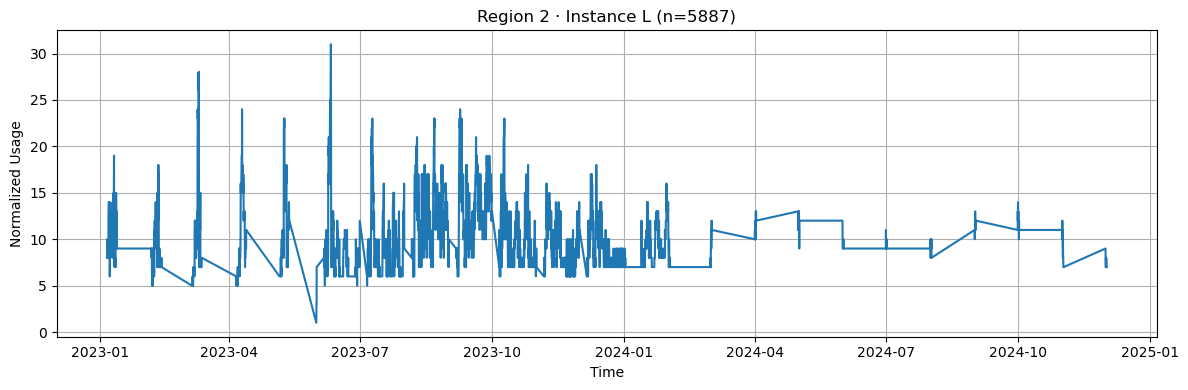

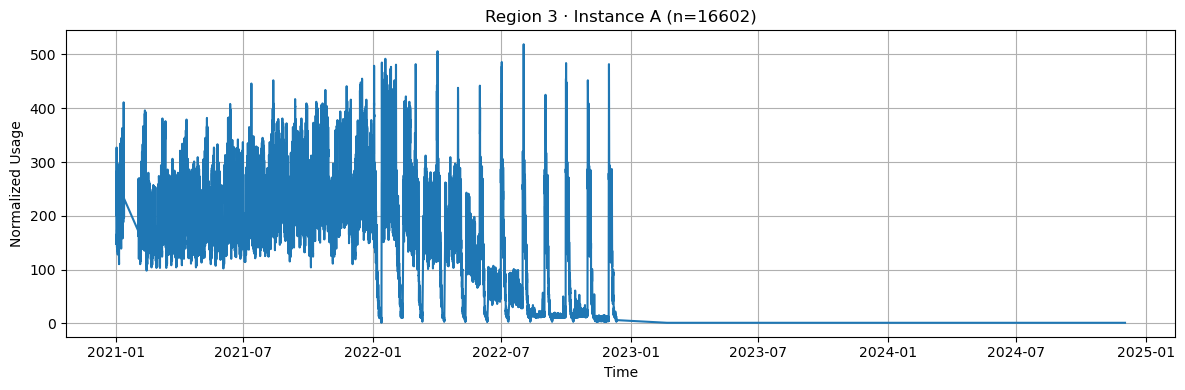

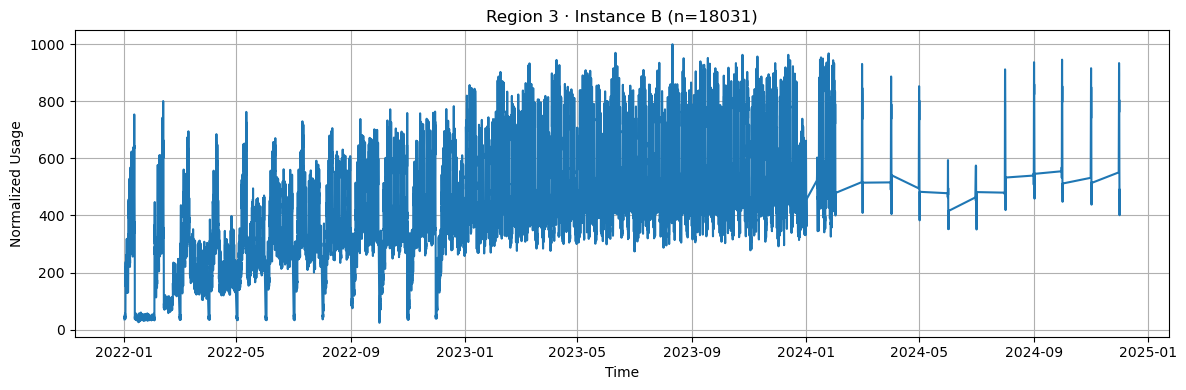

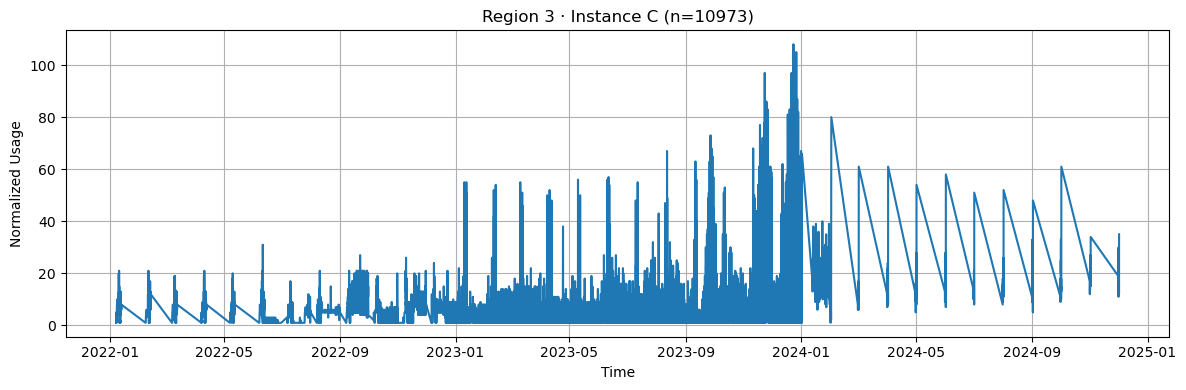

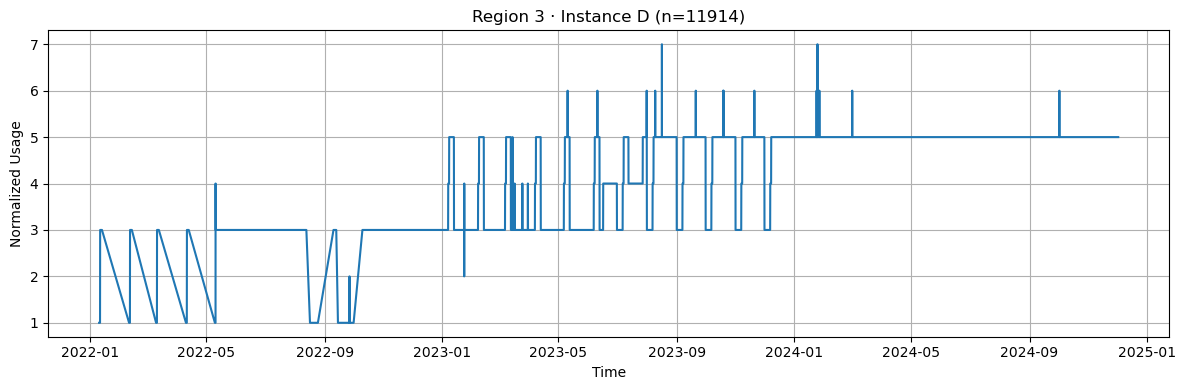

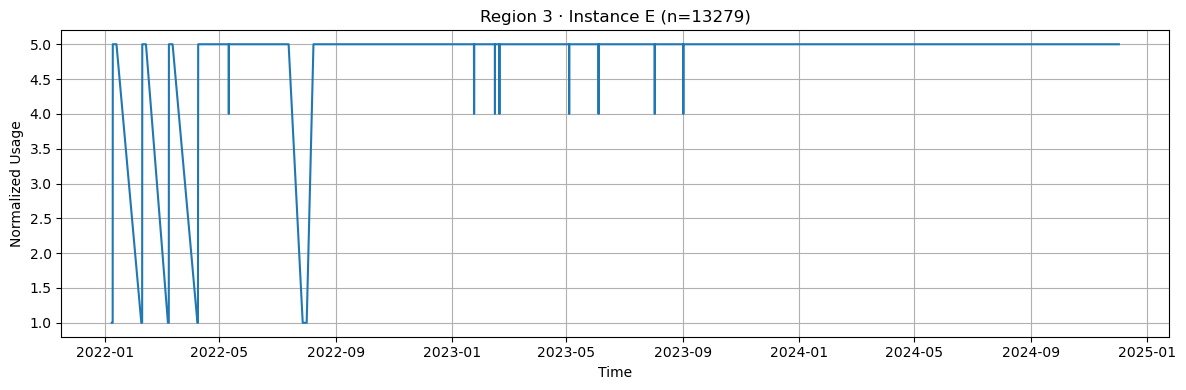

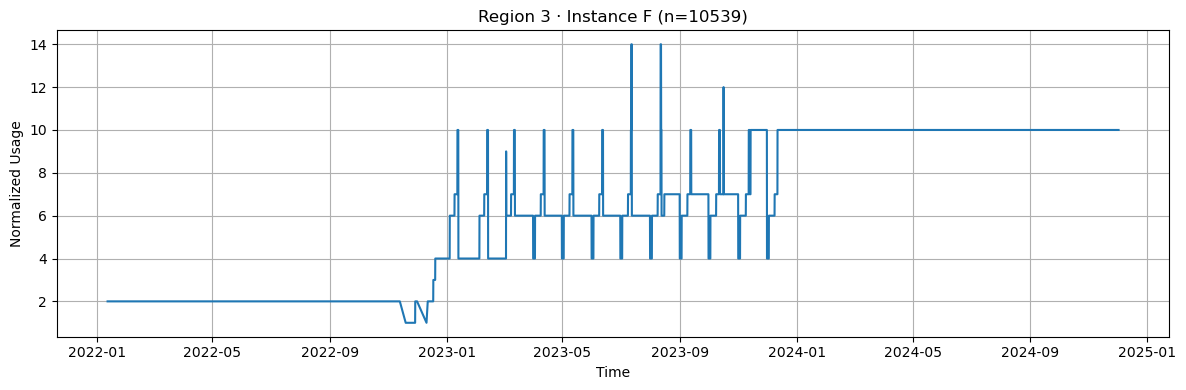

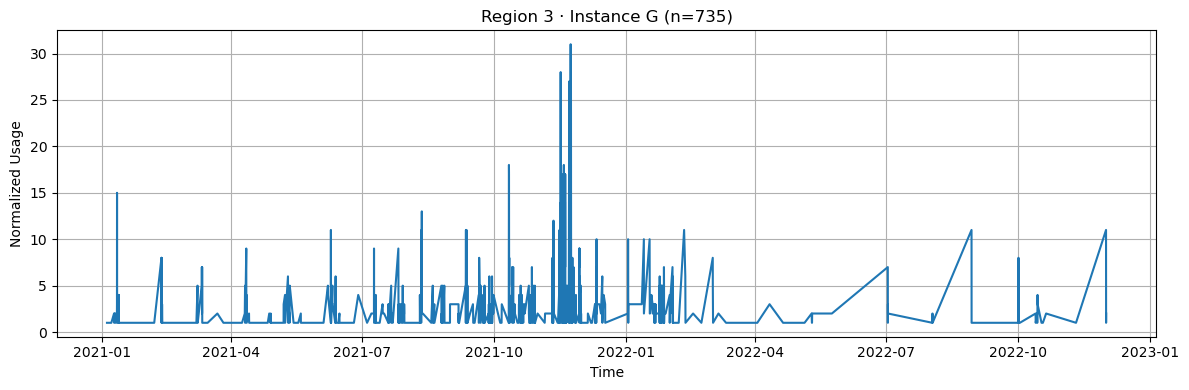

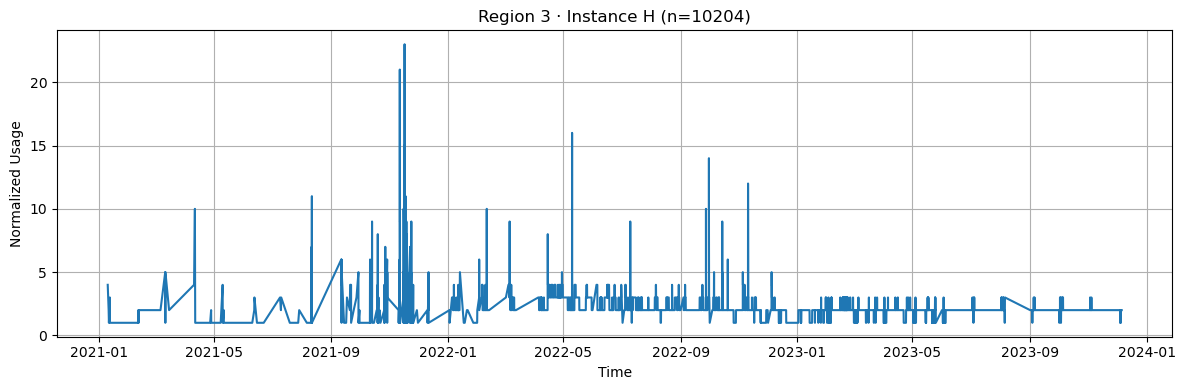

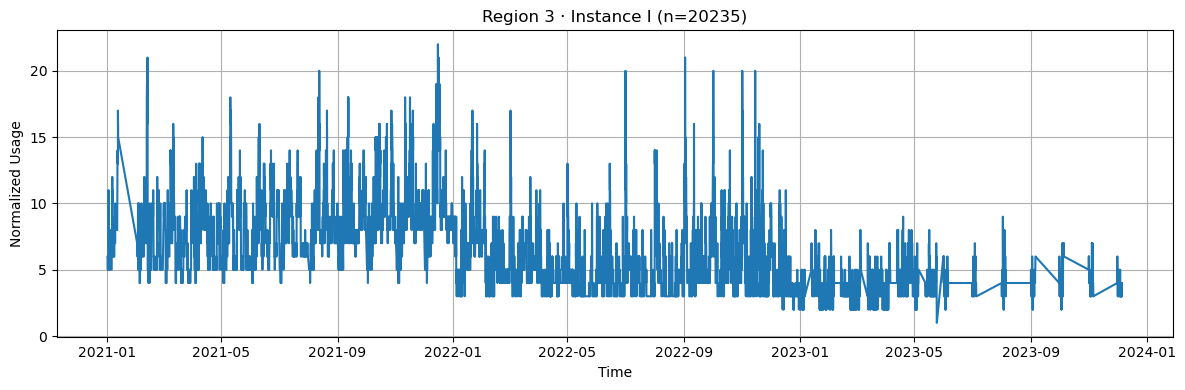

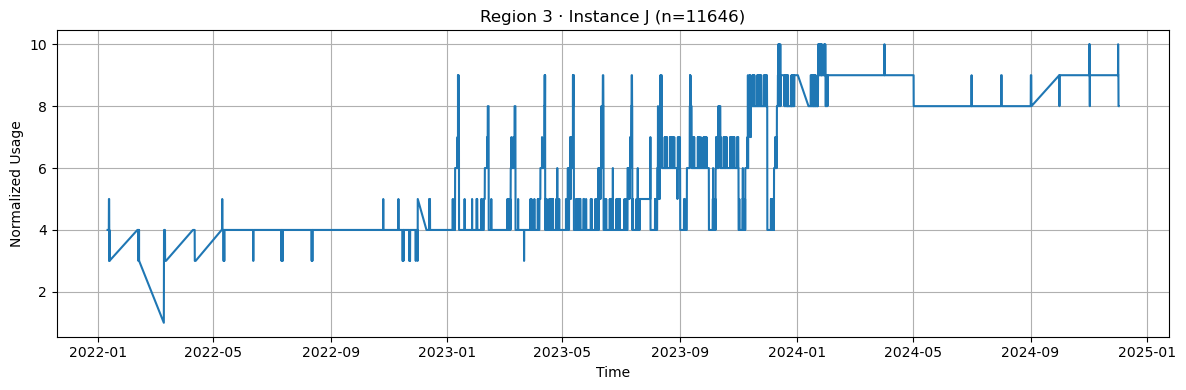

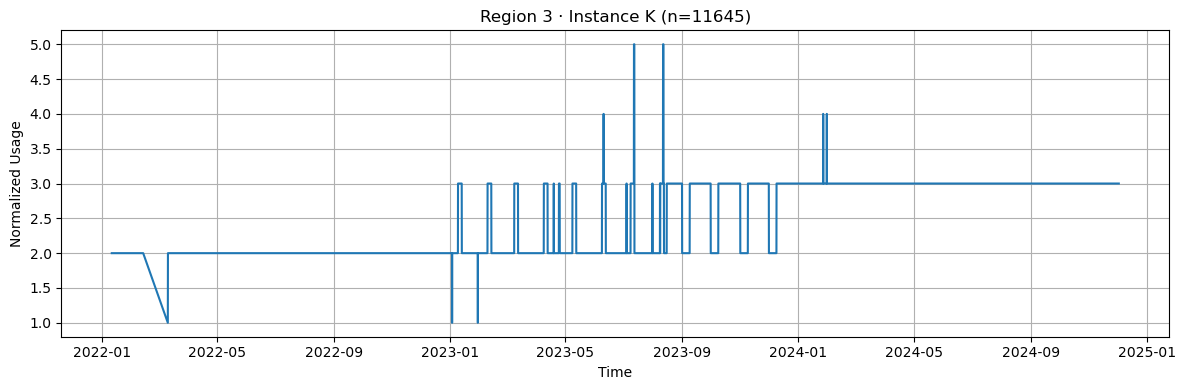

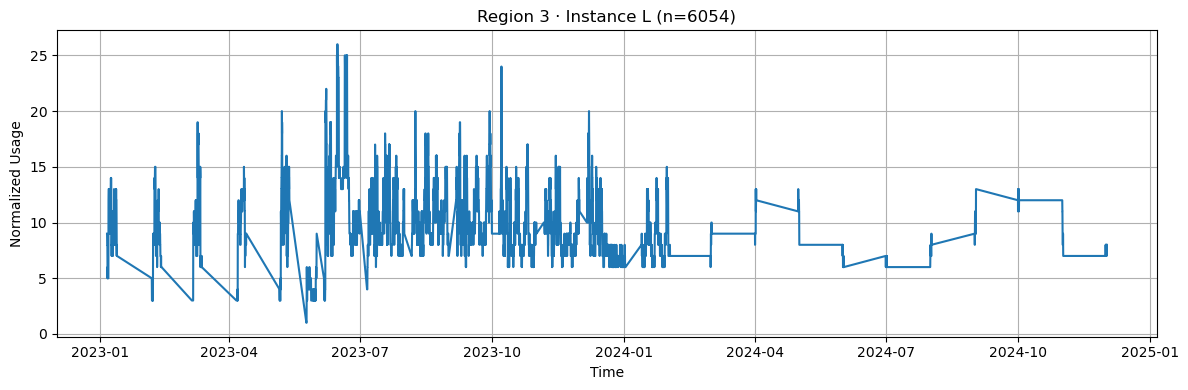

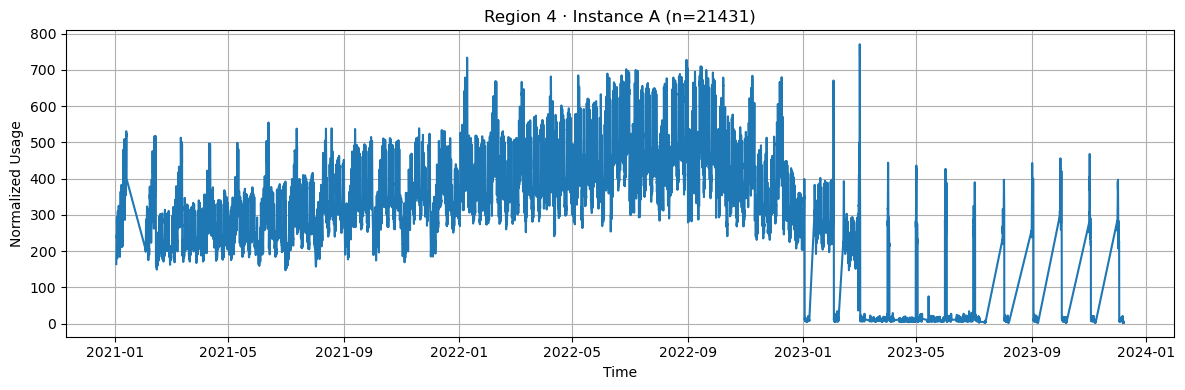

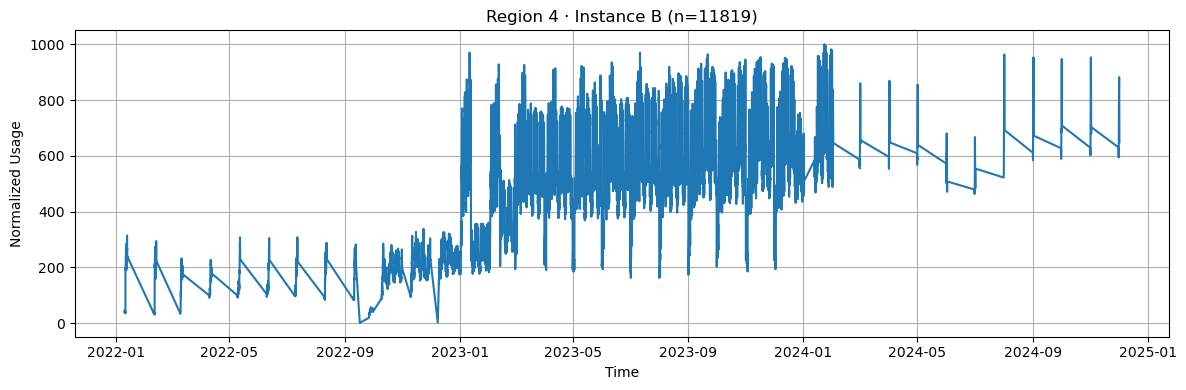

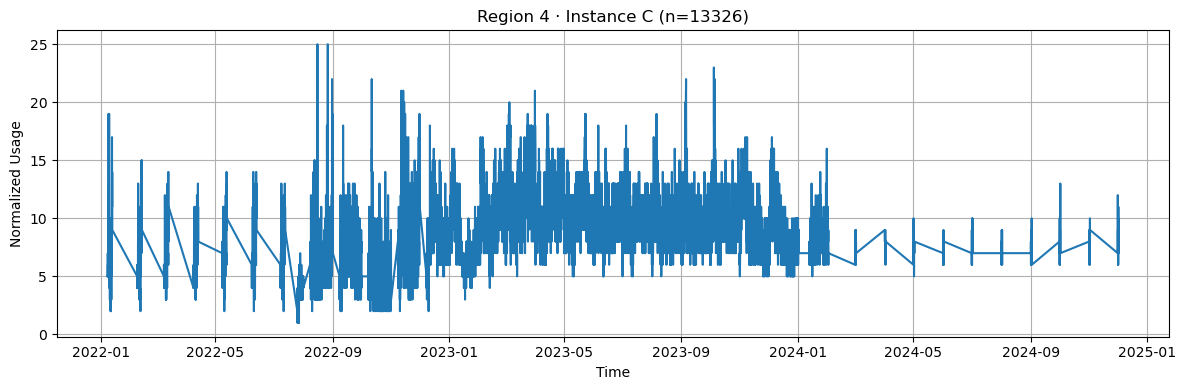

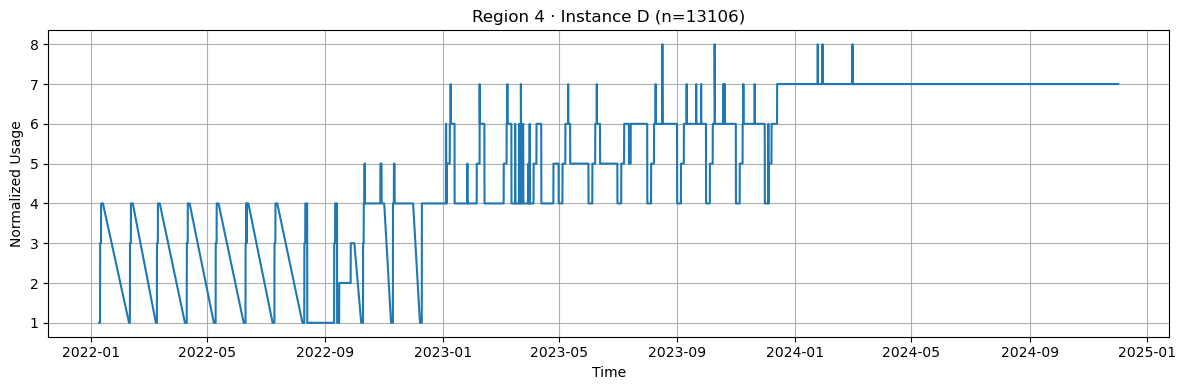

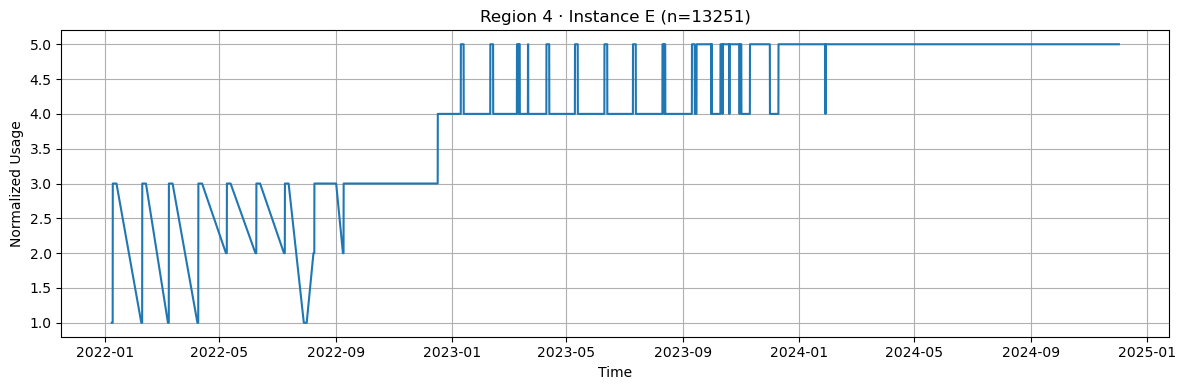

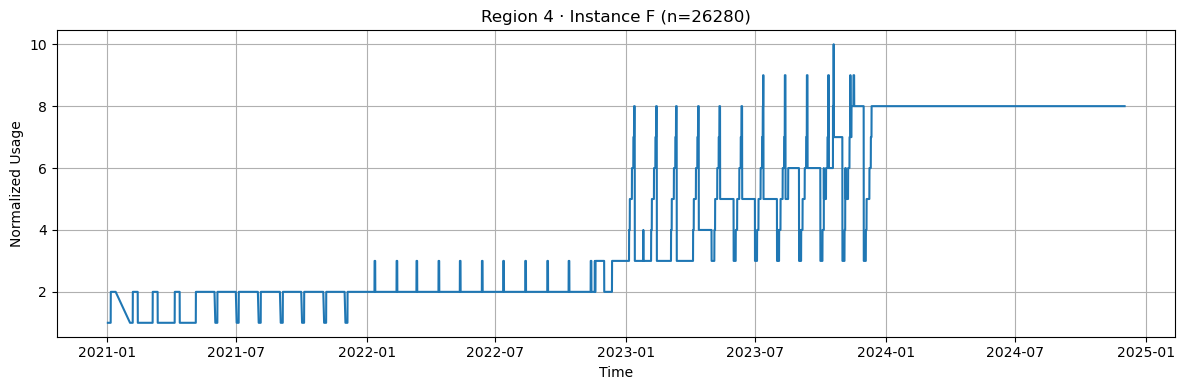

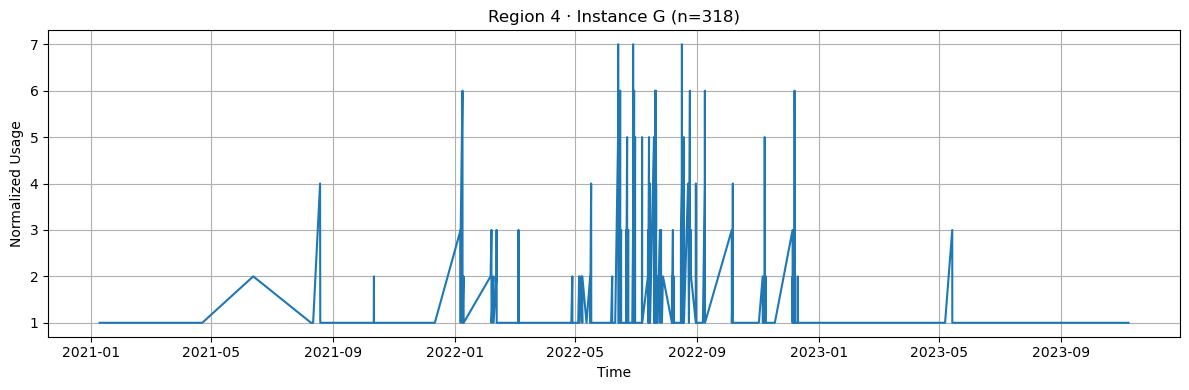

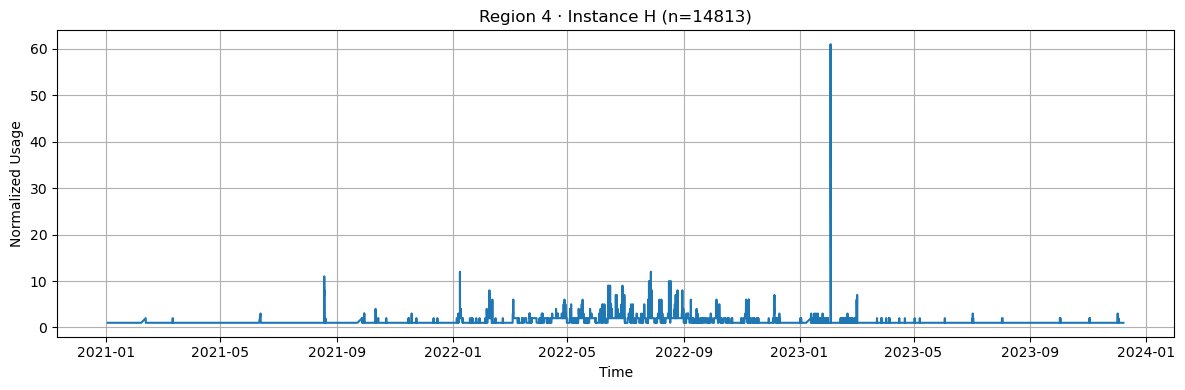

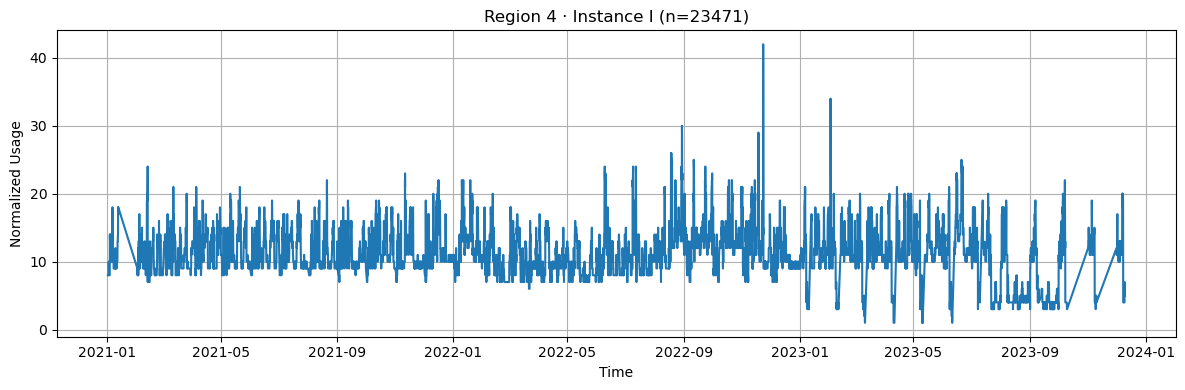

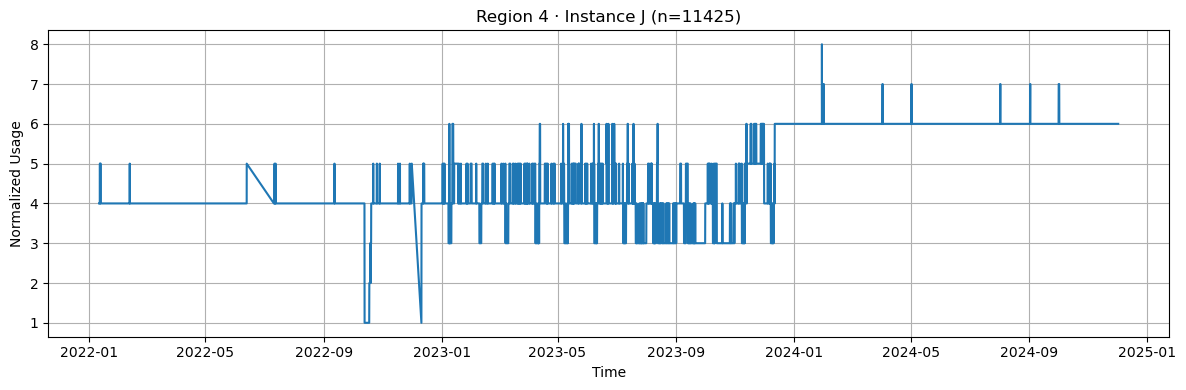

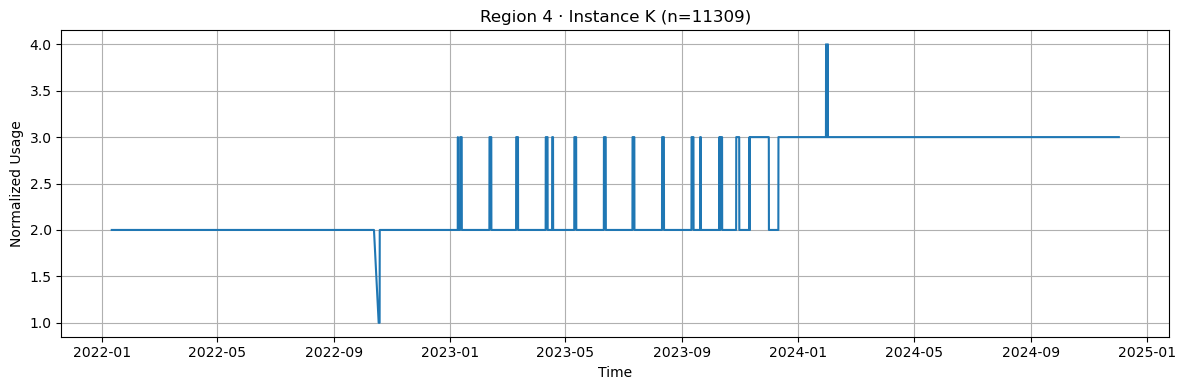

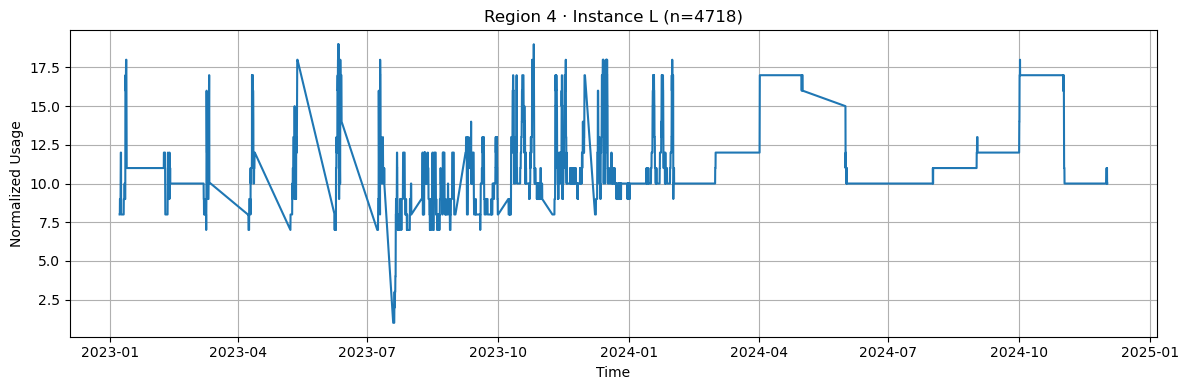

In [4]:
import matplotlib.pyplot as plt

# Plot line graph for each region-instance combination
for (region, inst), grp in df.groupby(['REGION_NUM', 'INSTANCE_TYPE']):
    plt.figure(figsize=(12, 4))
    plt.plot(grp['USAGE_HOUR'], grp['NORM_USAGE'], linestyle='-', linewidth=1.5)
    plt.title(f'Region {region} · Instance {inst} (n={len(grp)})')
    plt.xlabel('Time')
    plt.ylabel('Normalized Usage')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


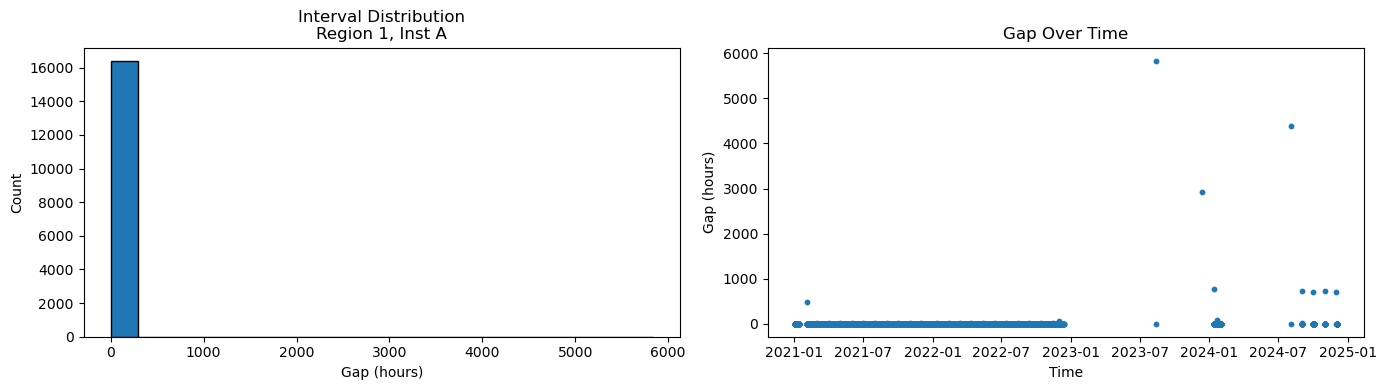

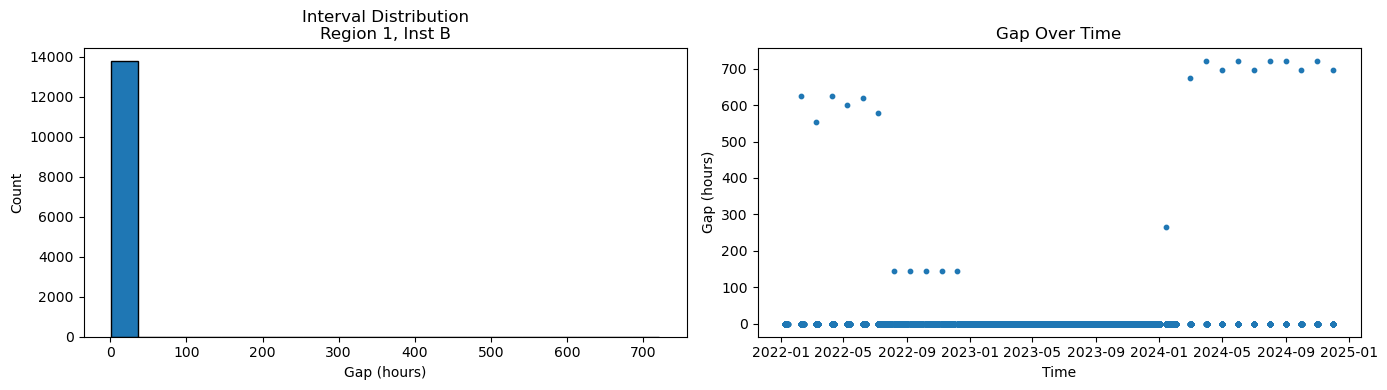

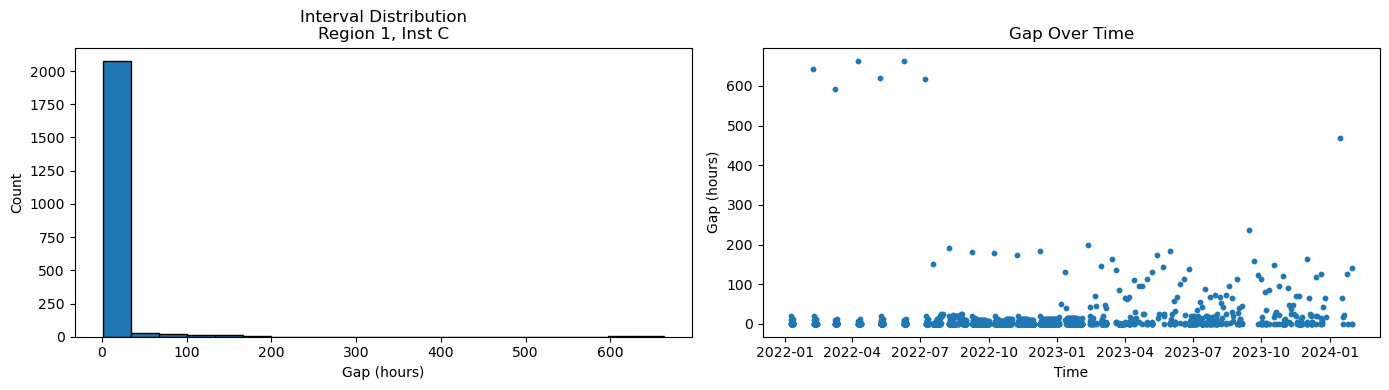

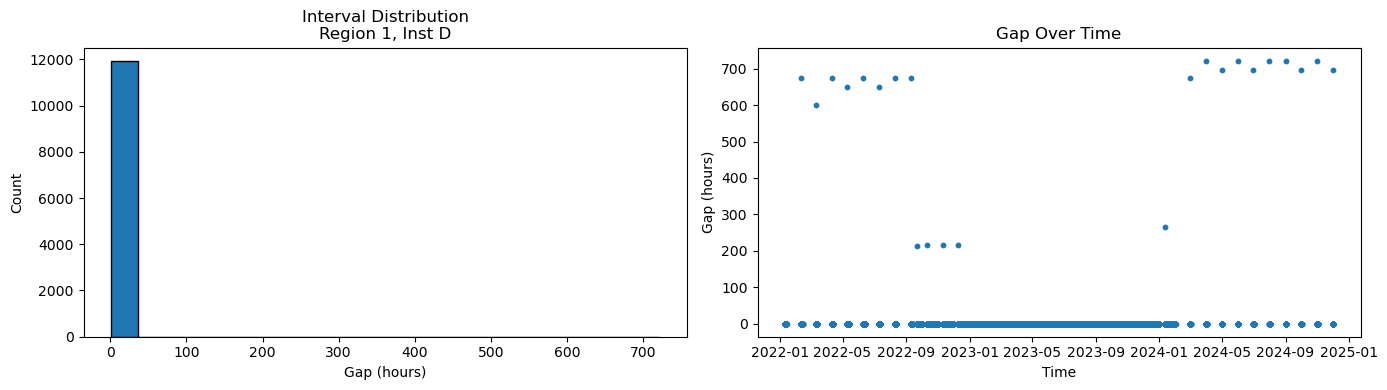

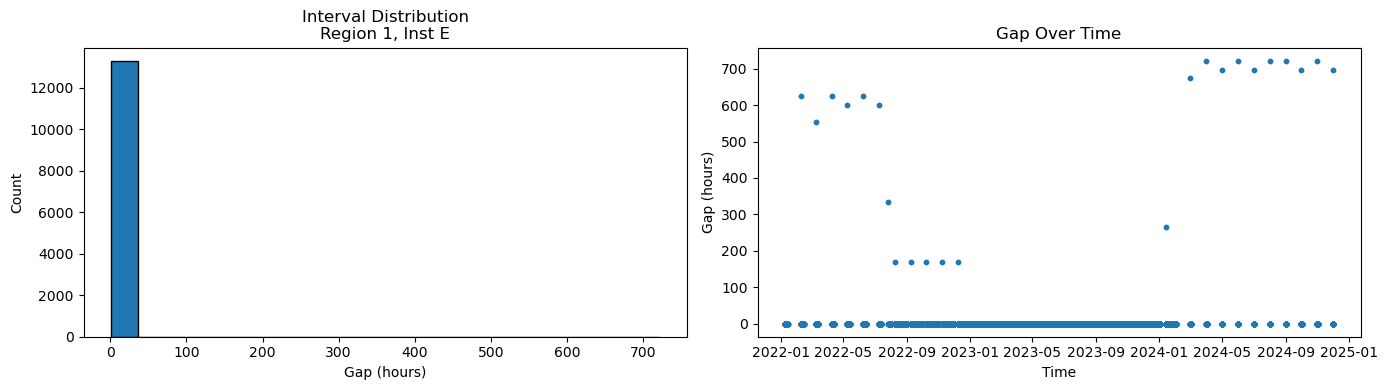

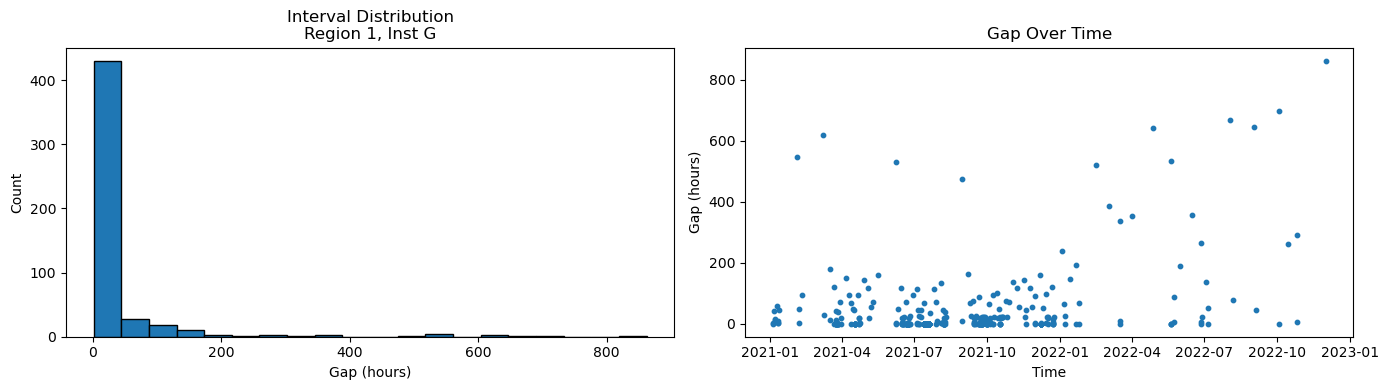

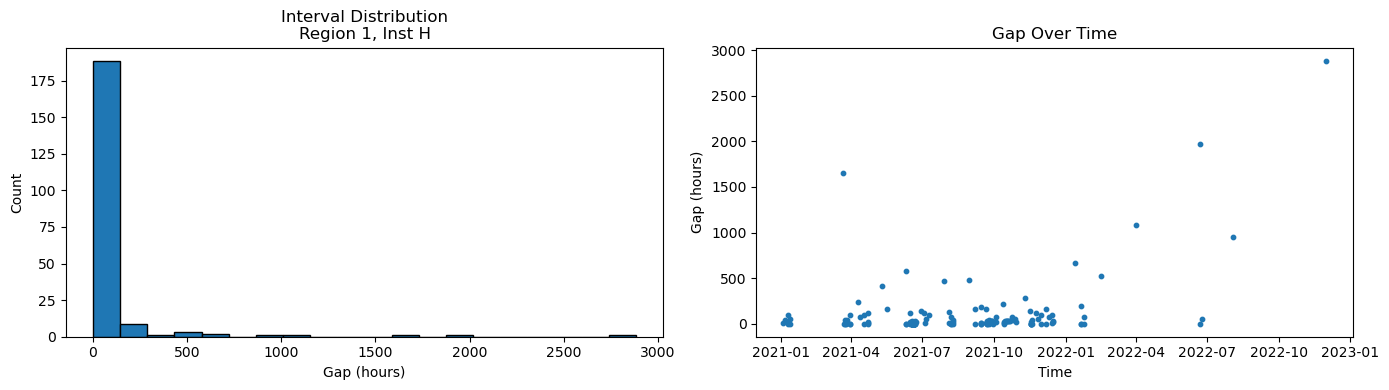

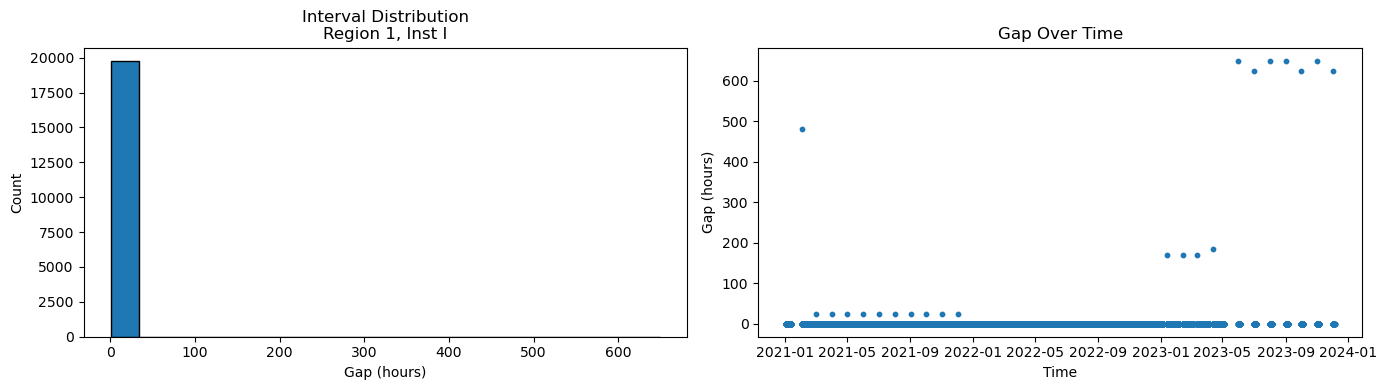

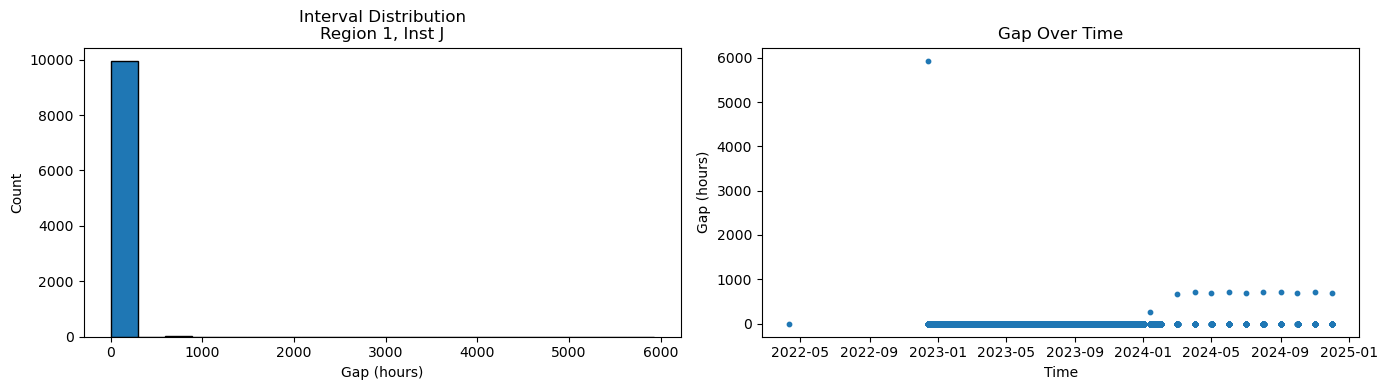

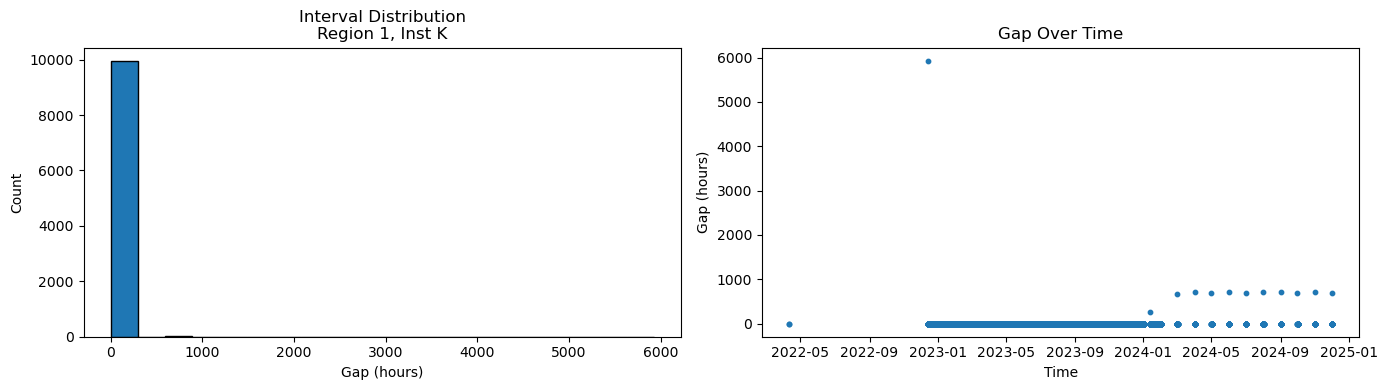

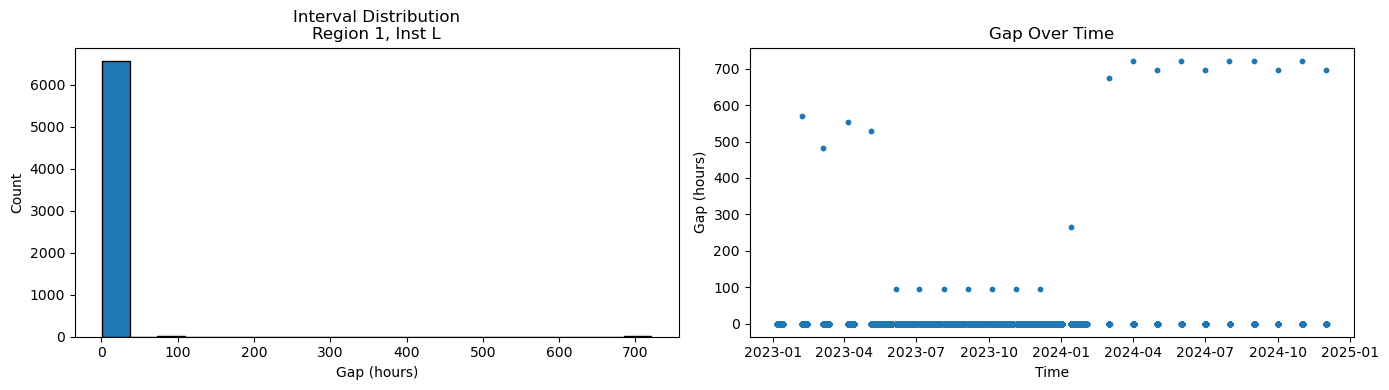

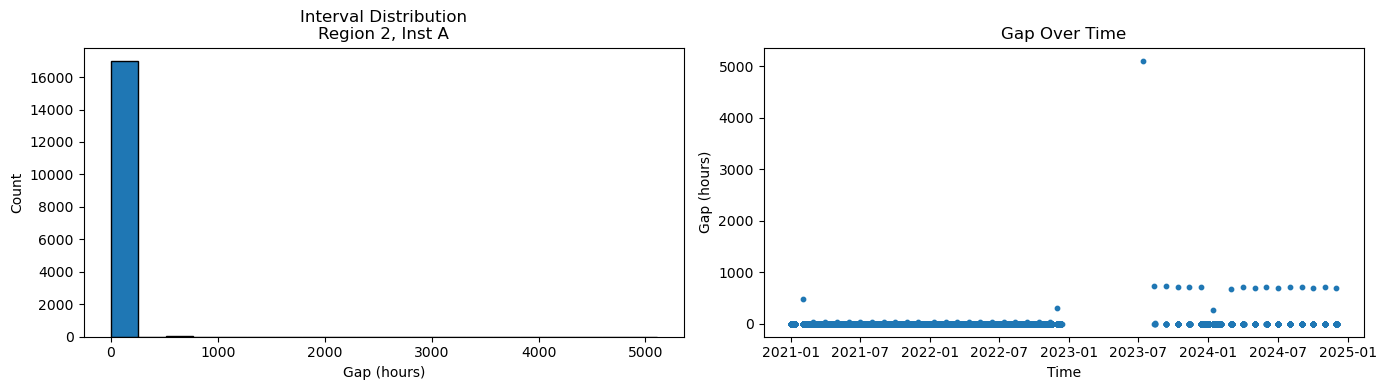

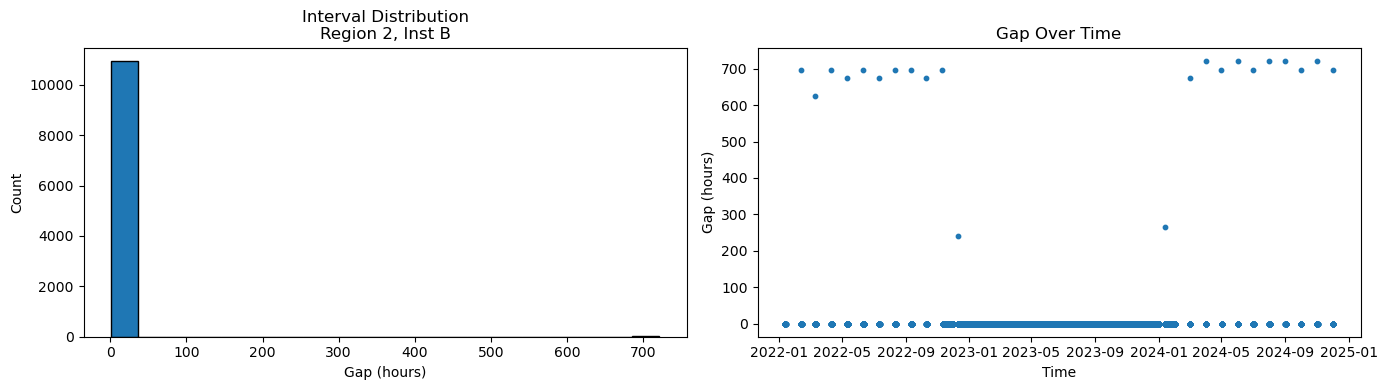

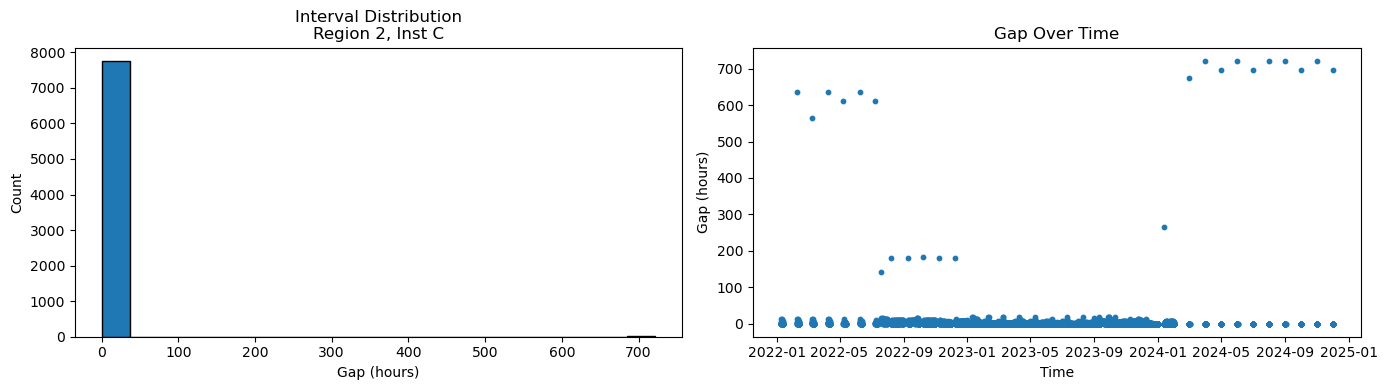

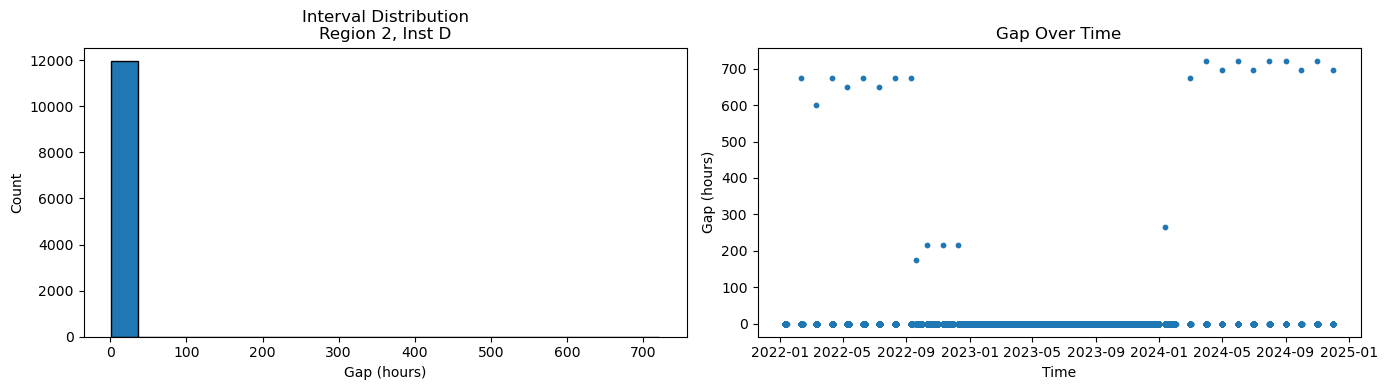

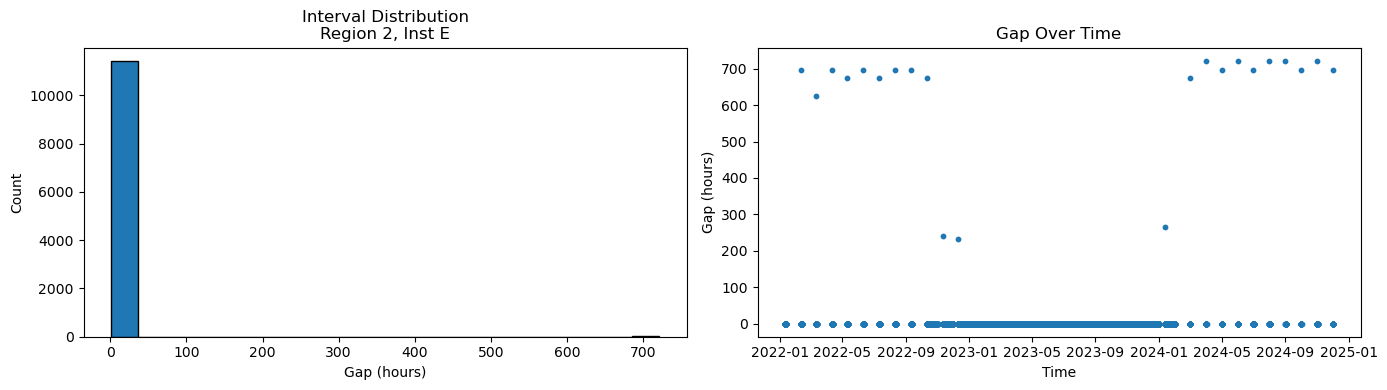

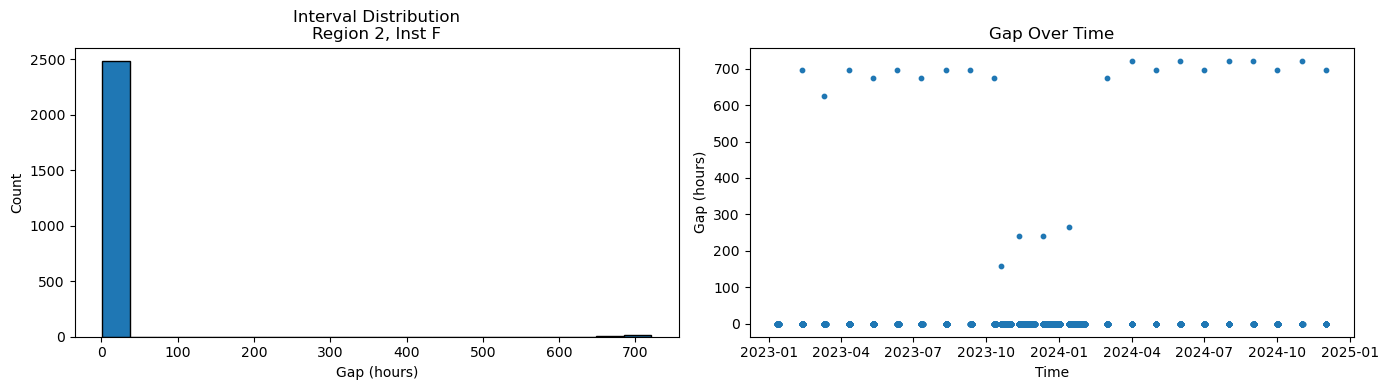

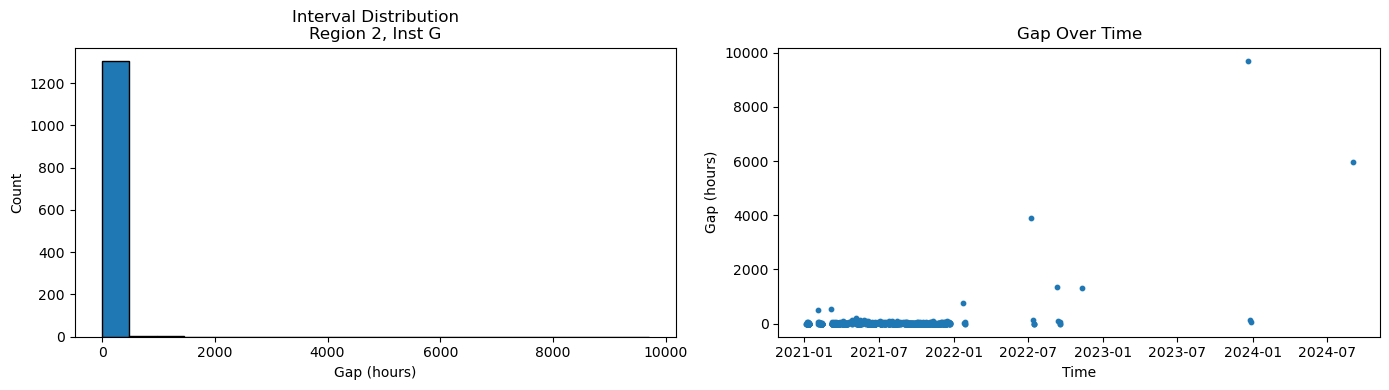

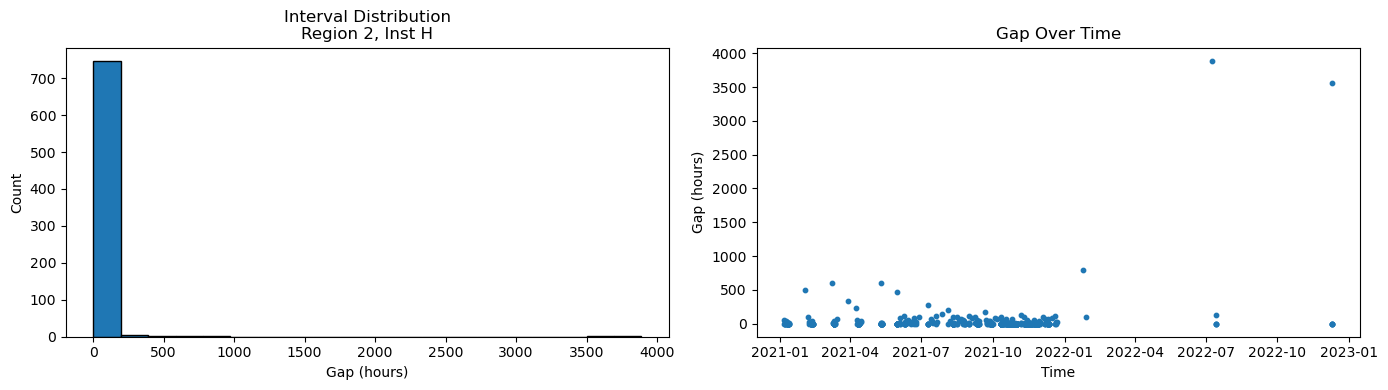

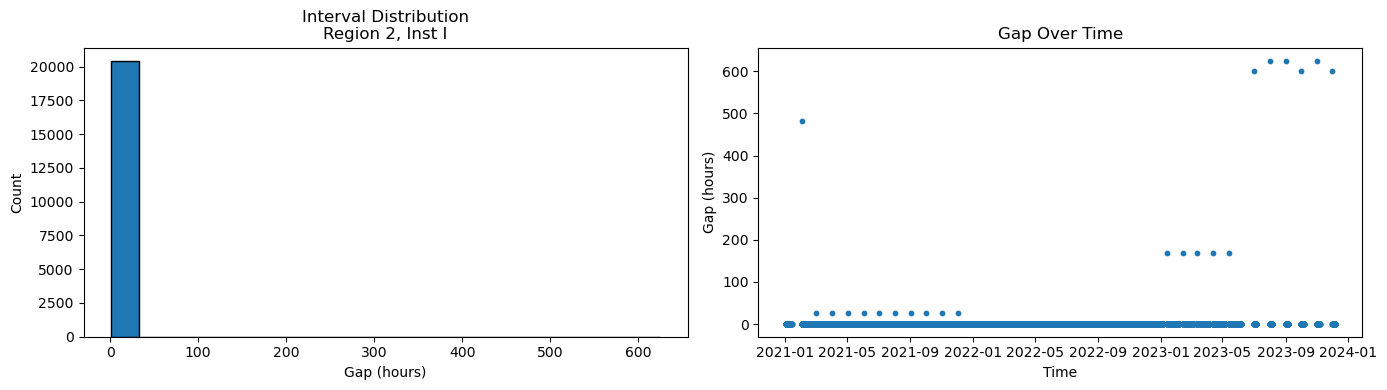

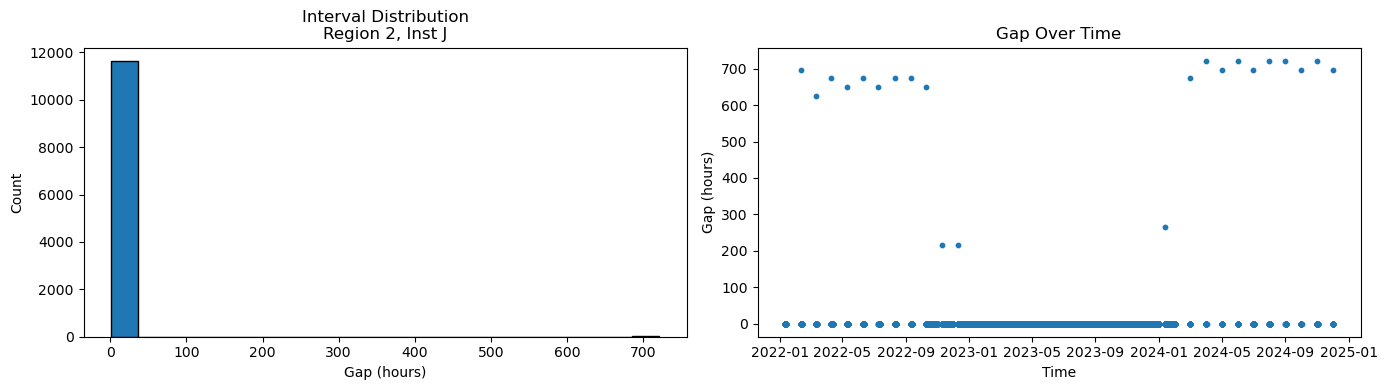

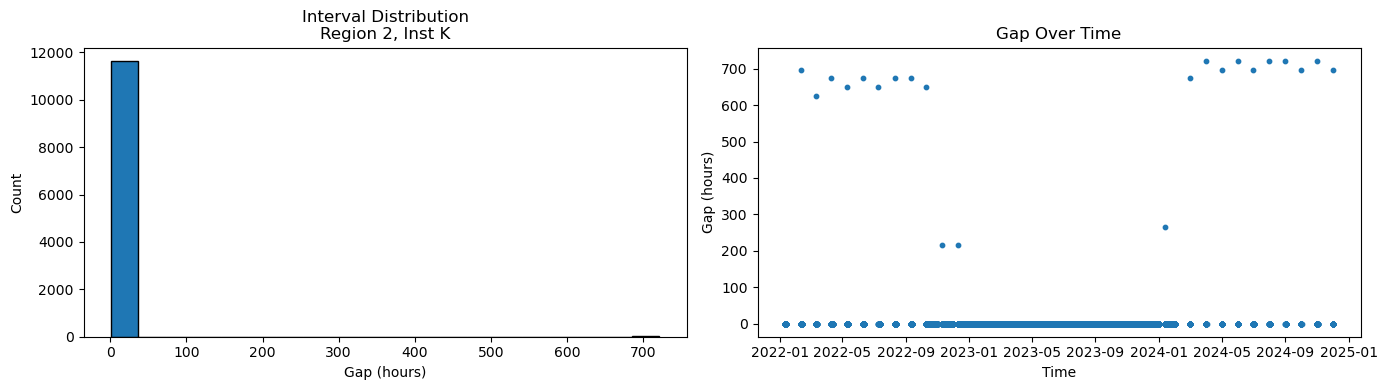

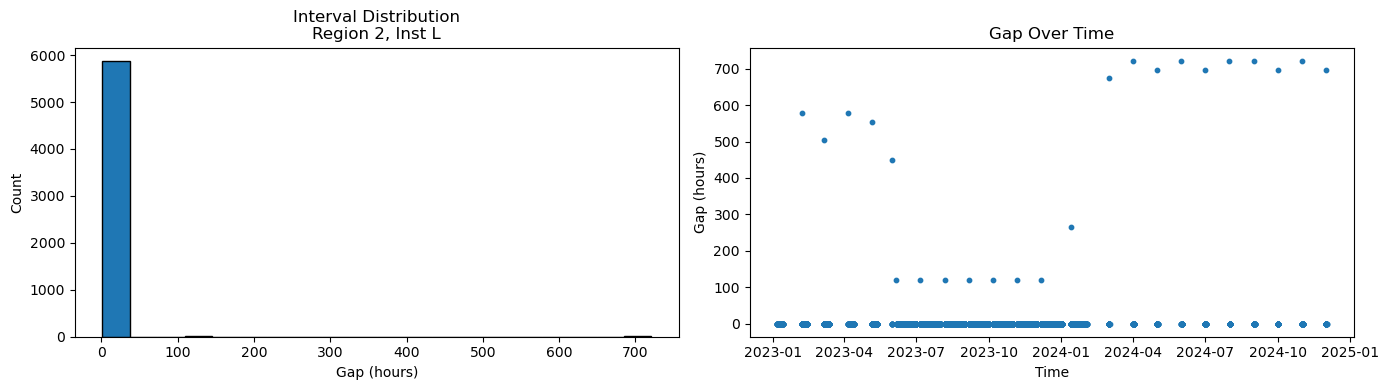

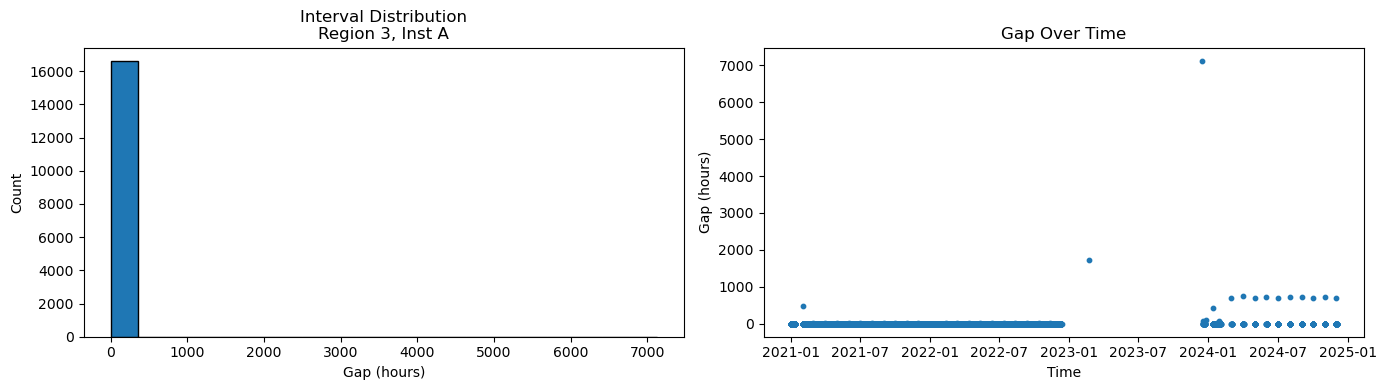

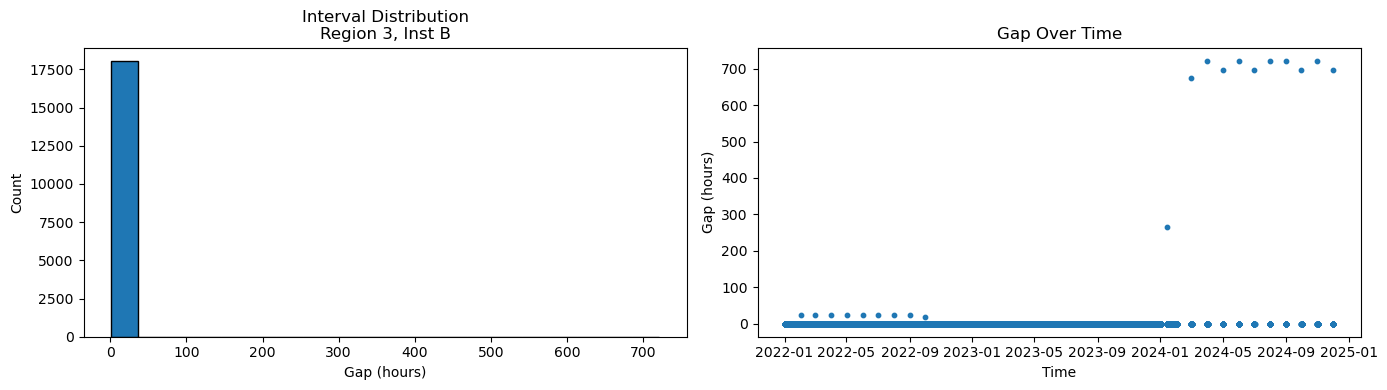

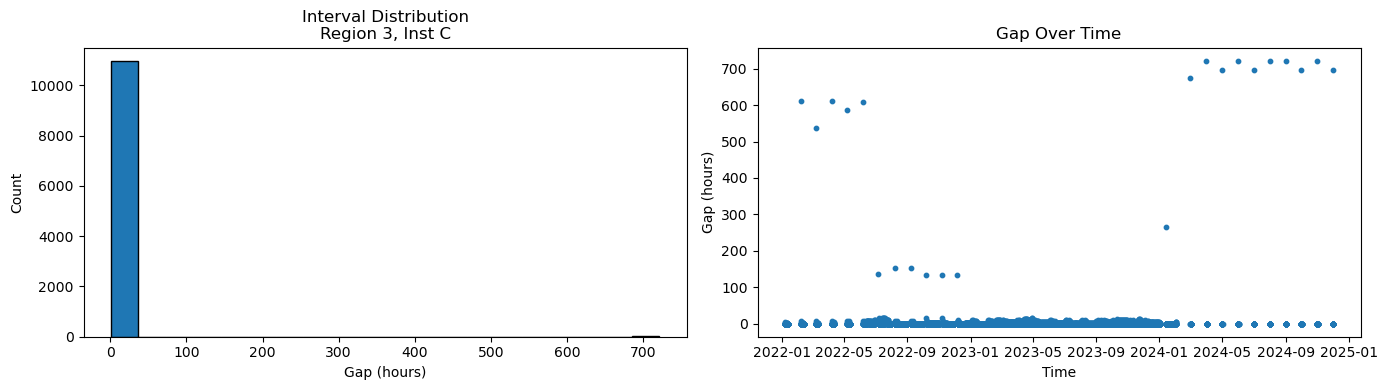

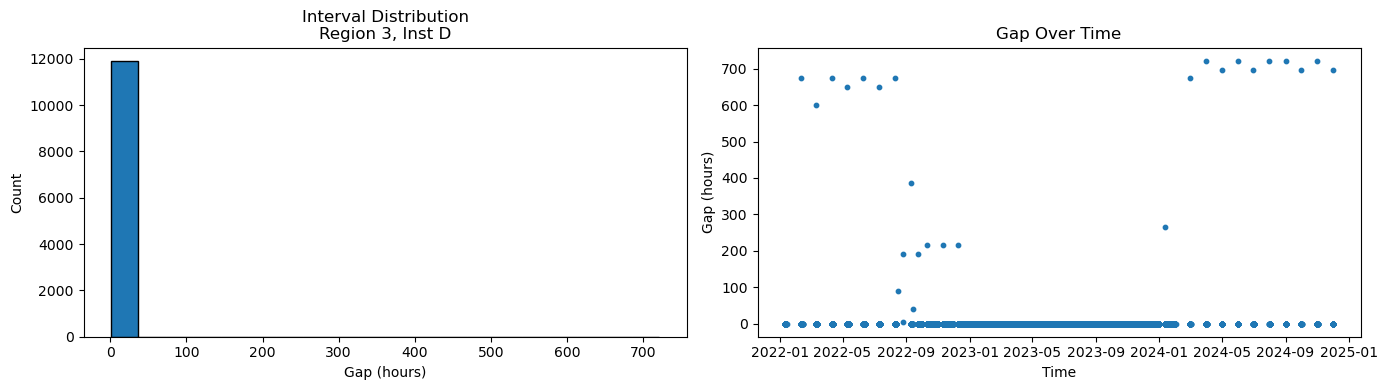

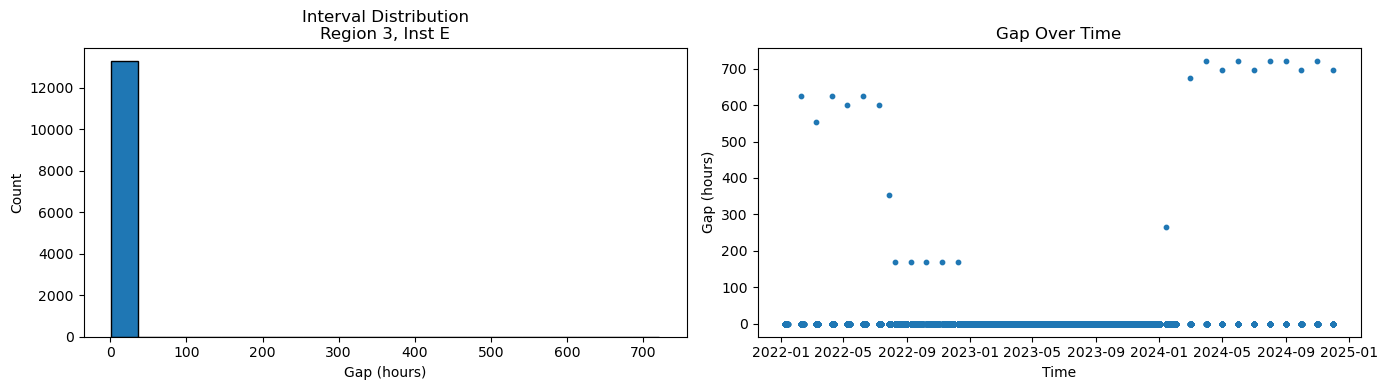

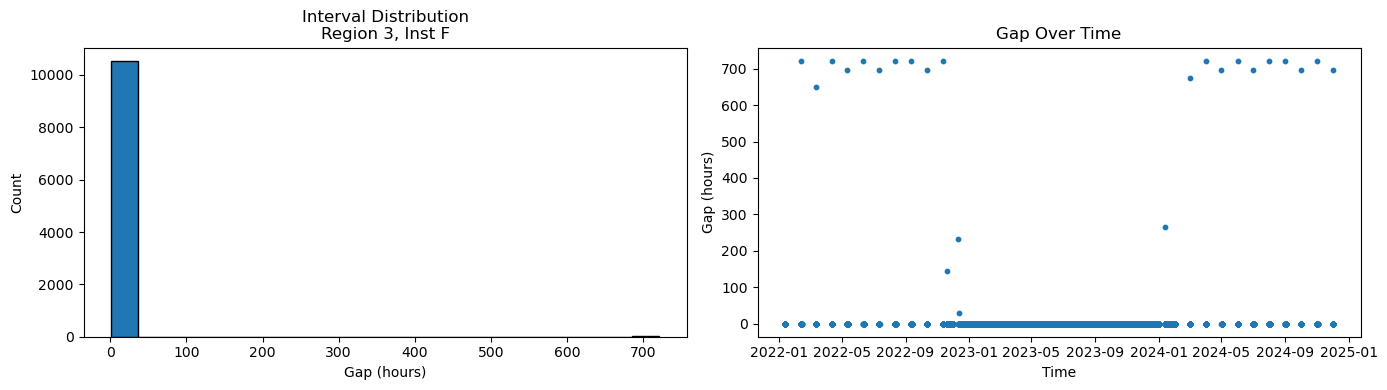

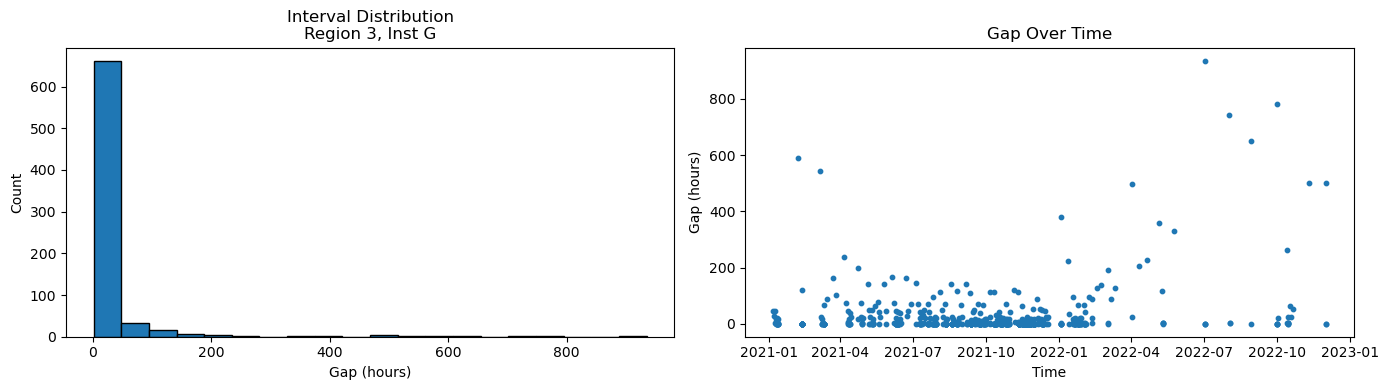

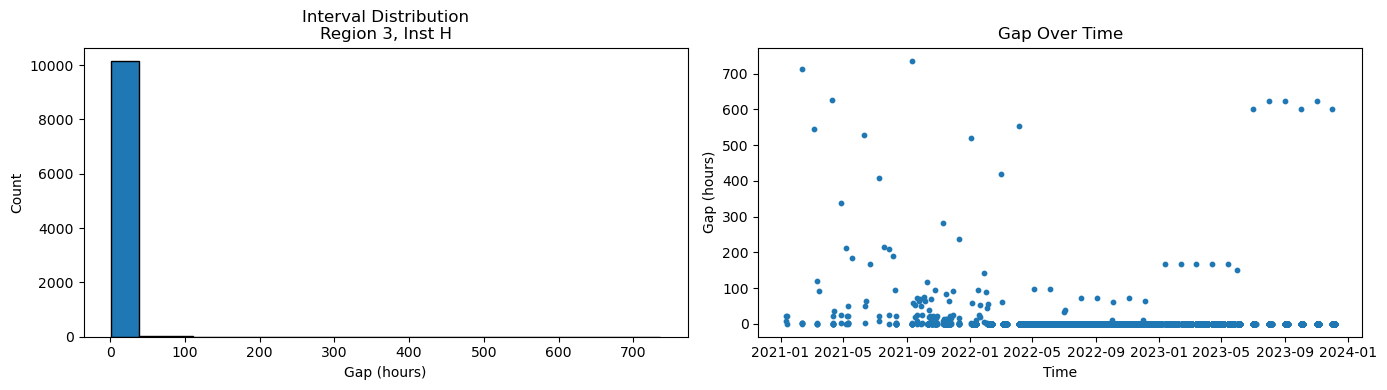

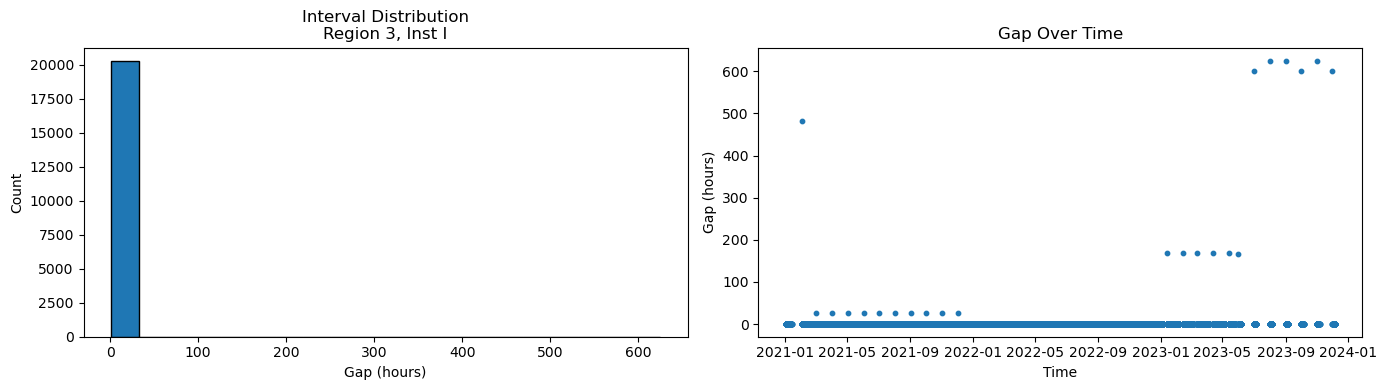

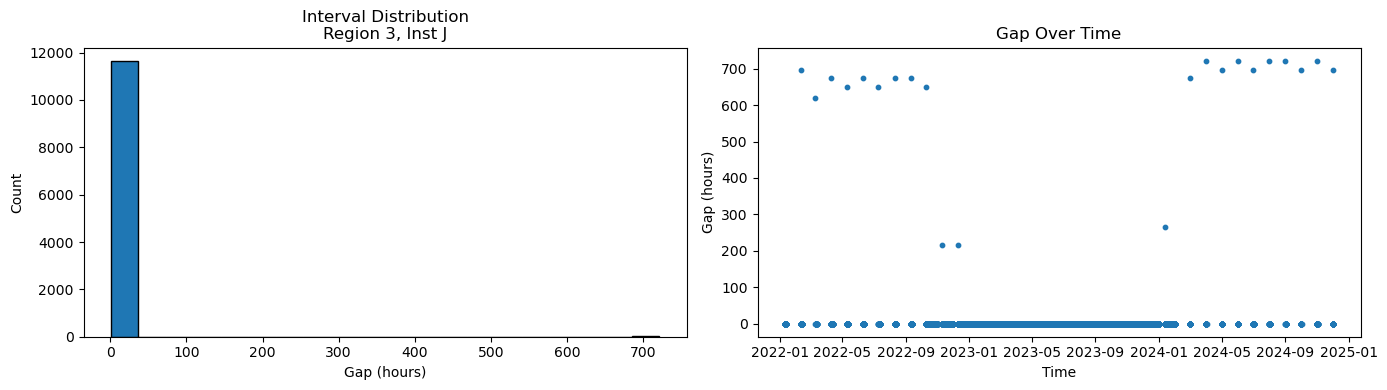

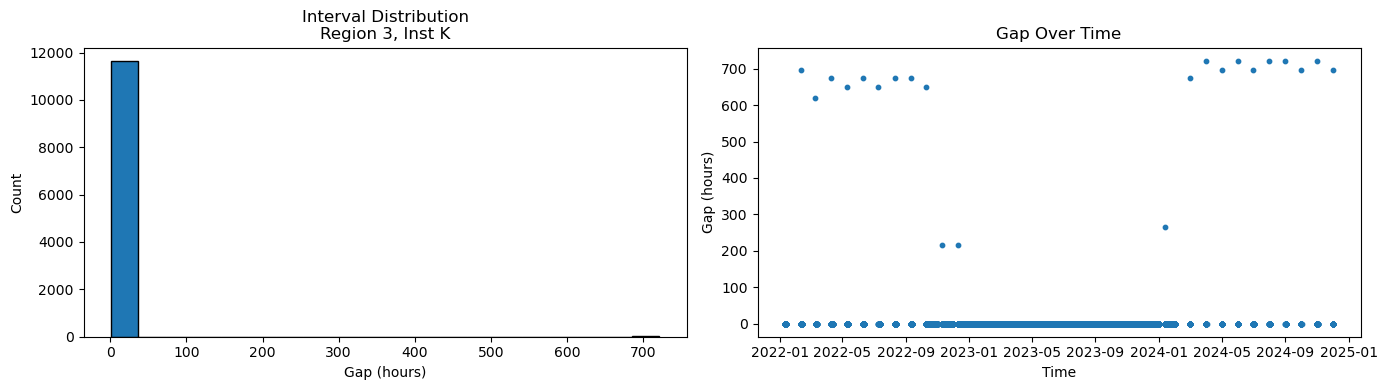

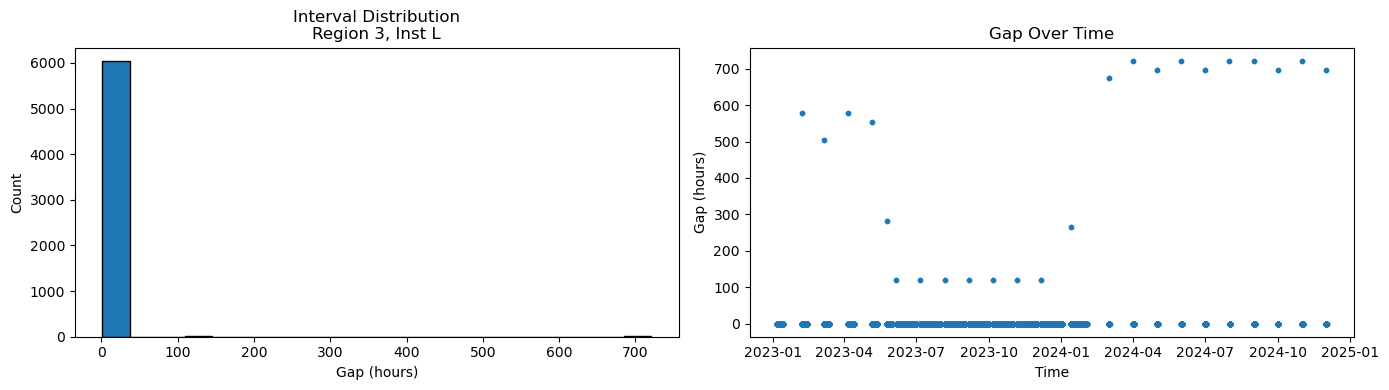

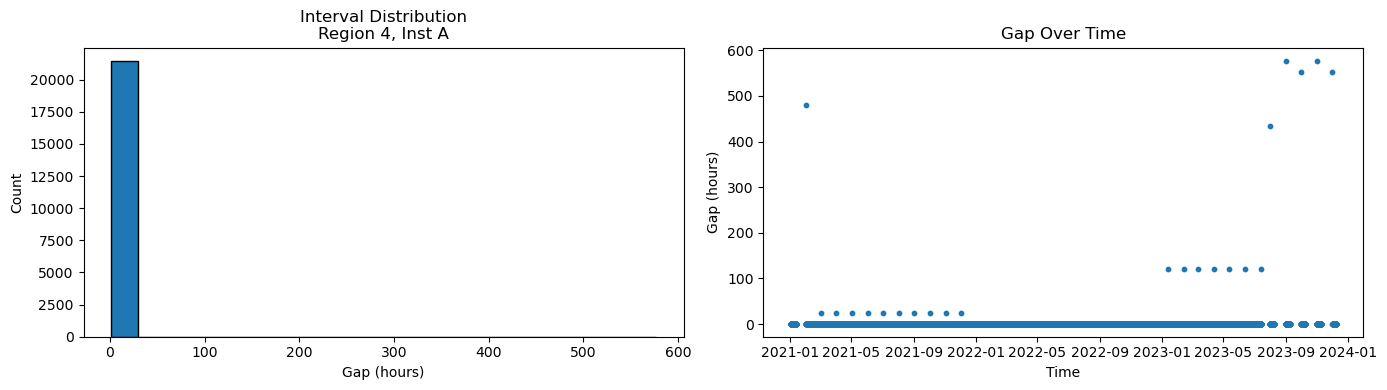

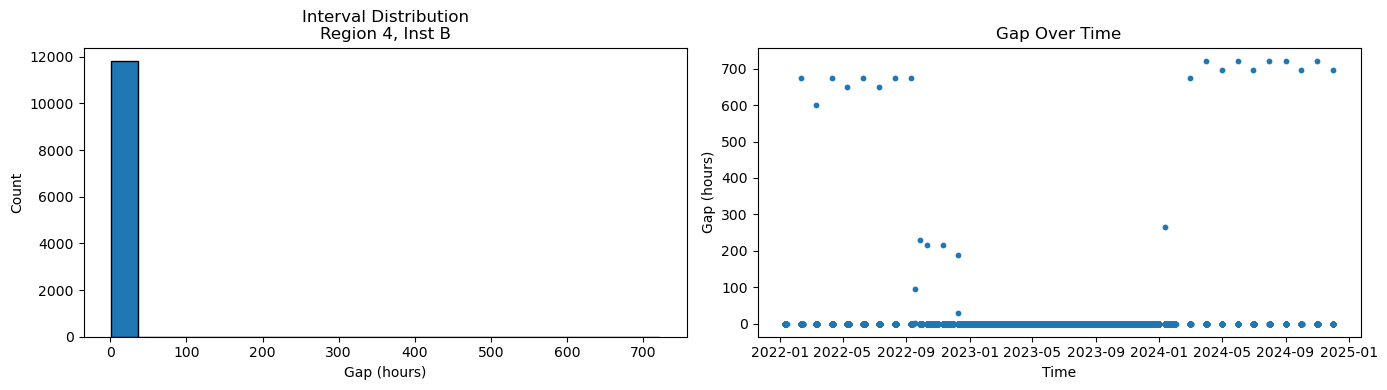

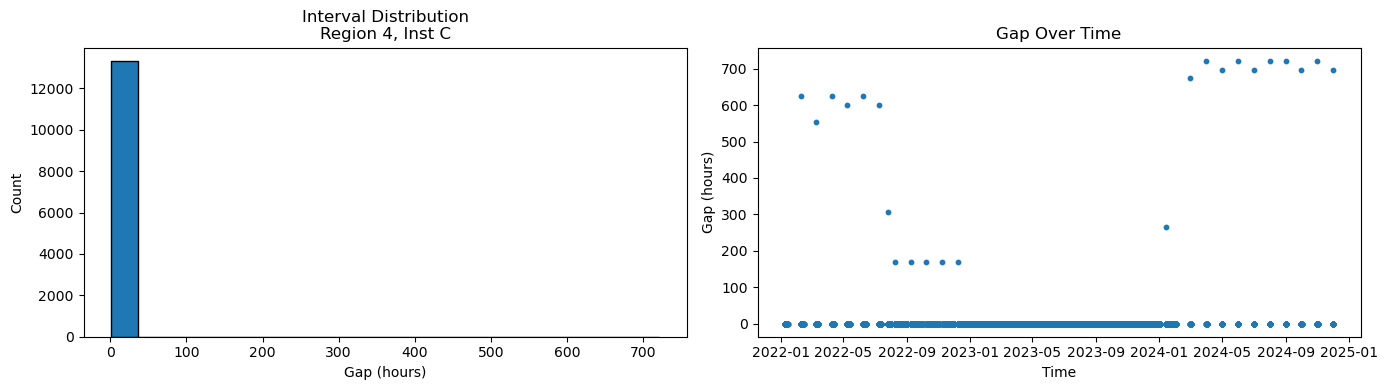

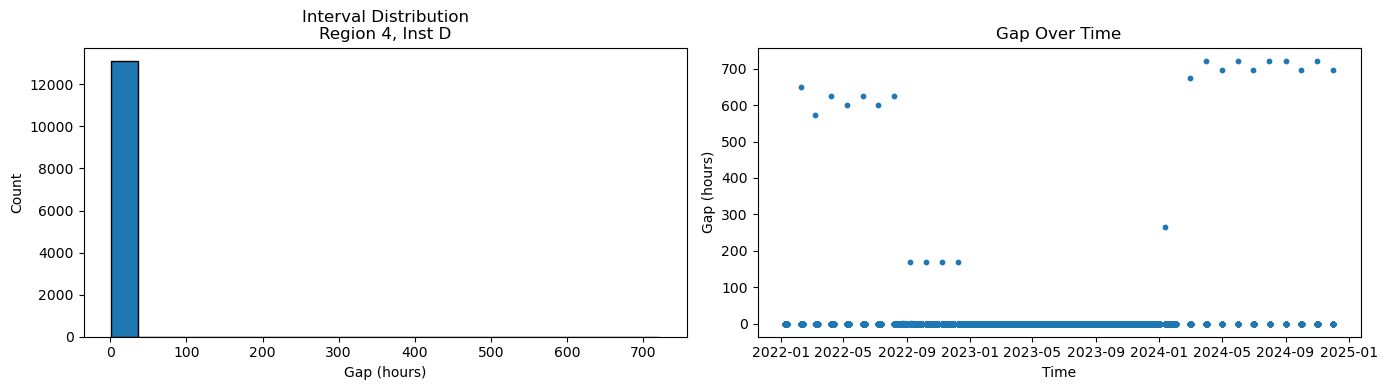

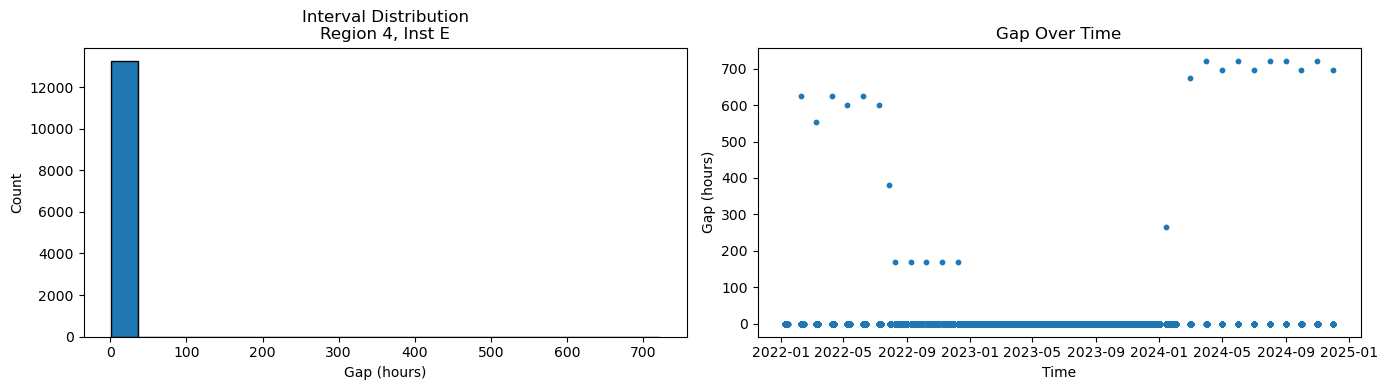

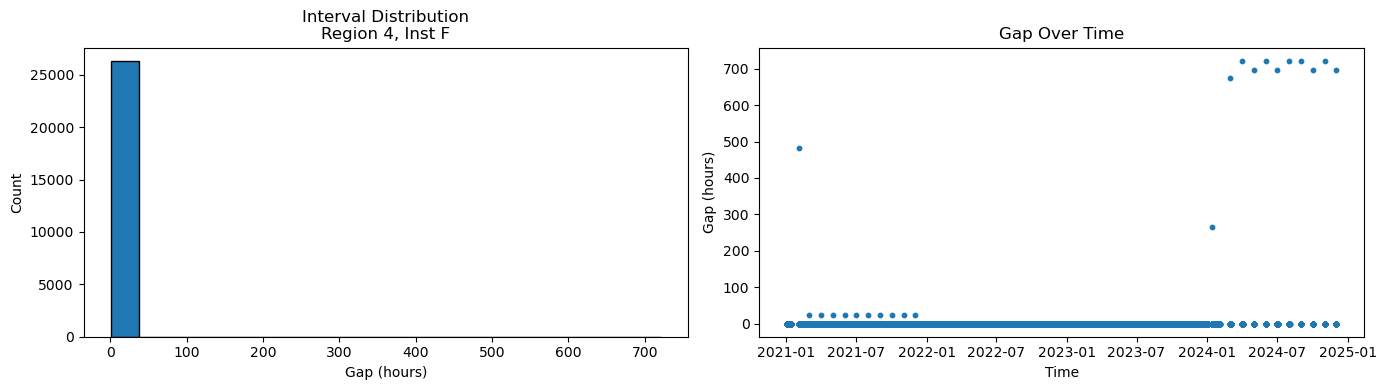

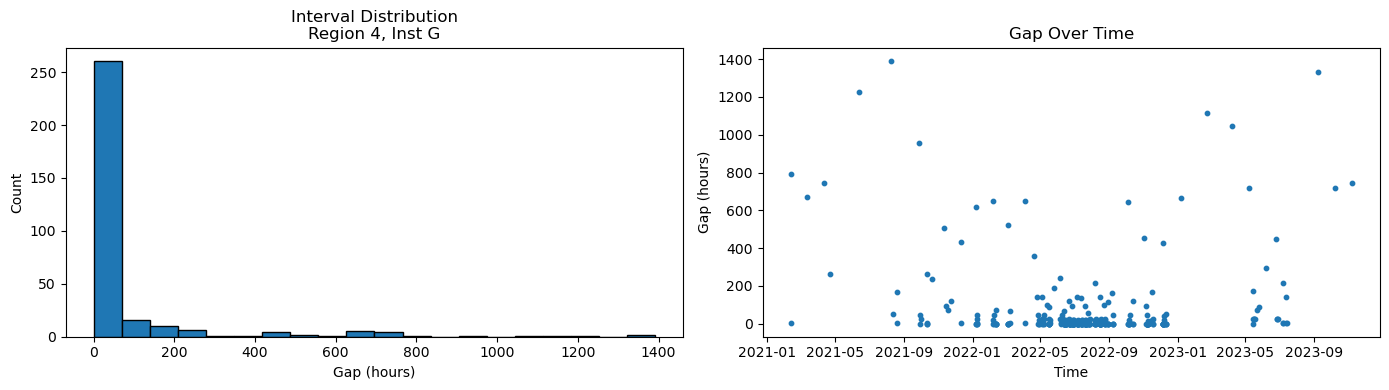

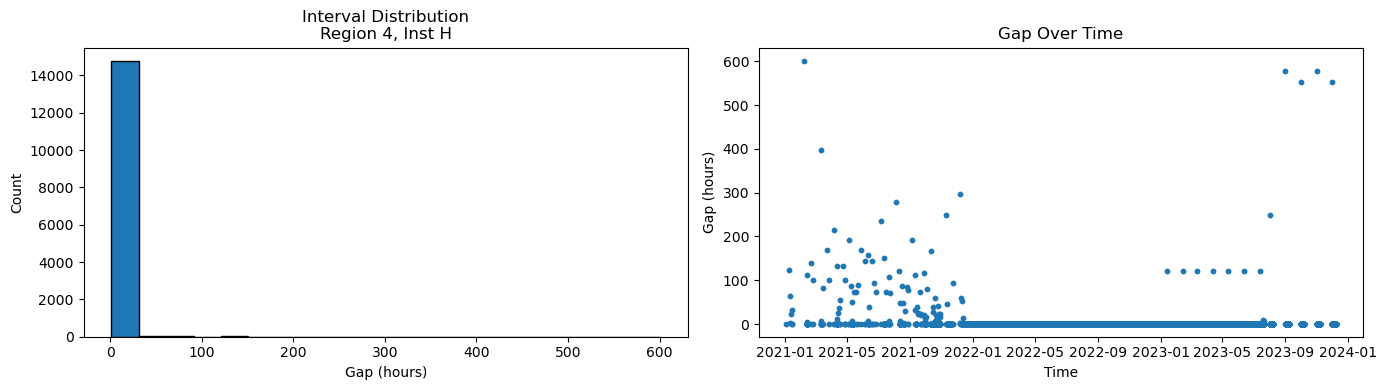

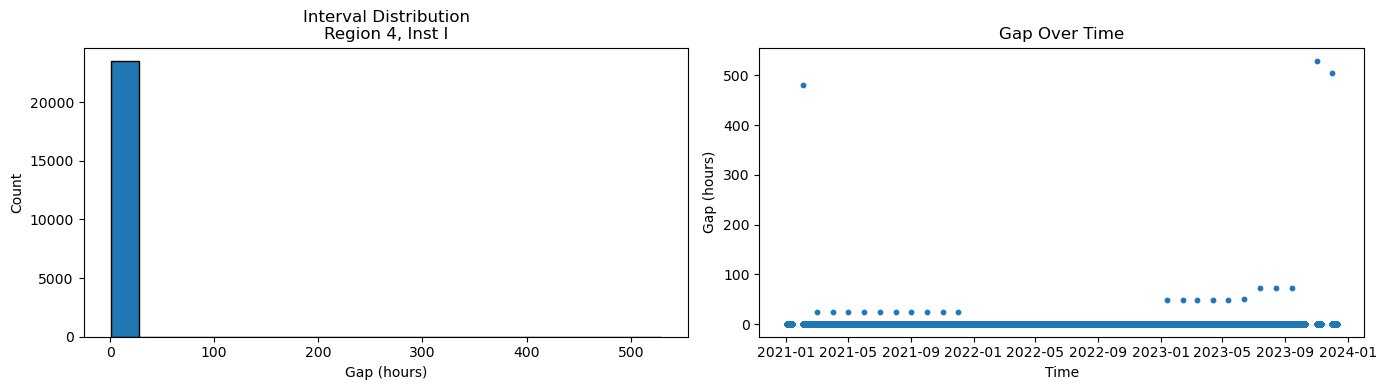

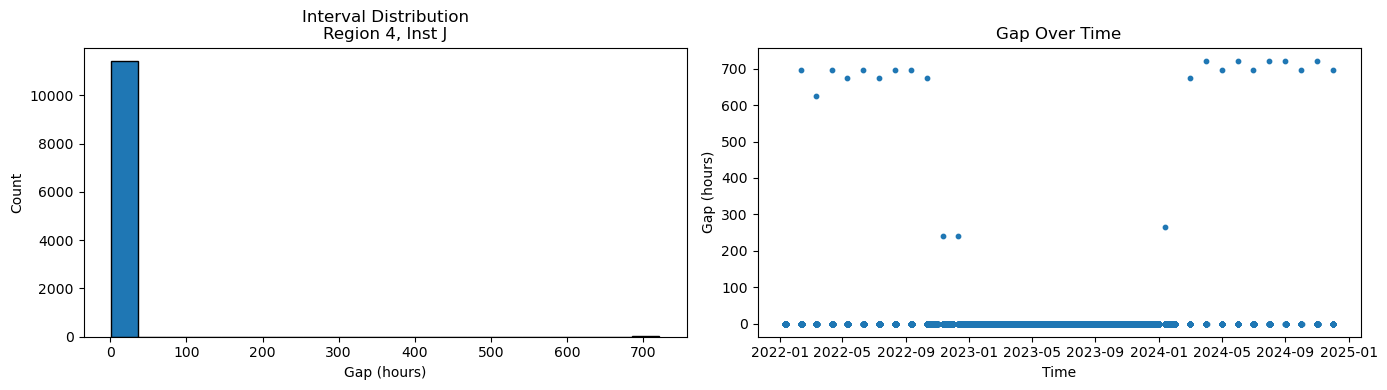

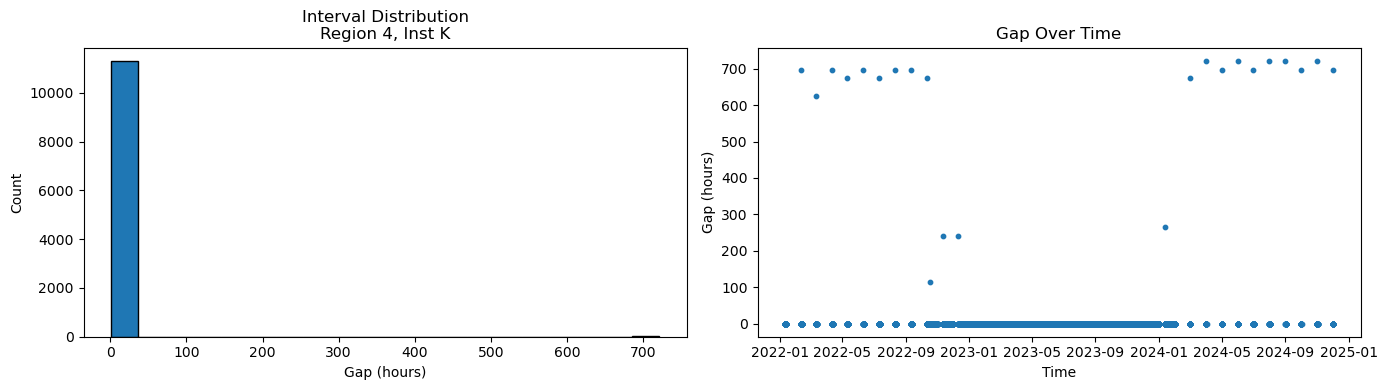

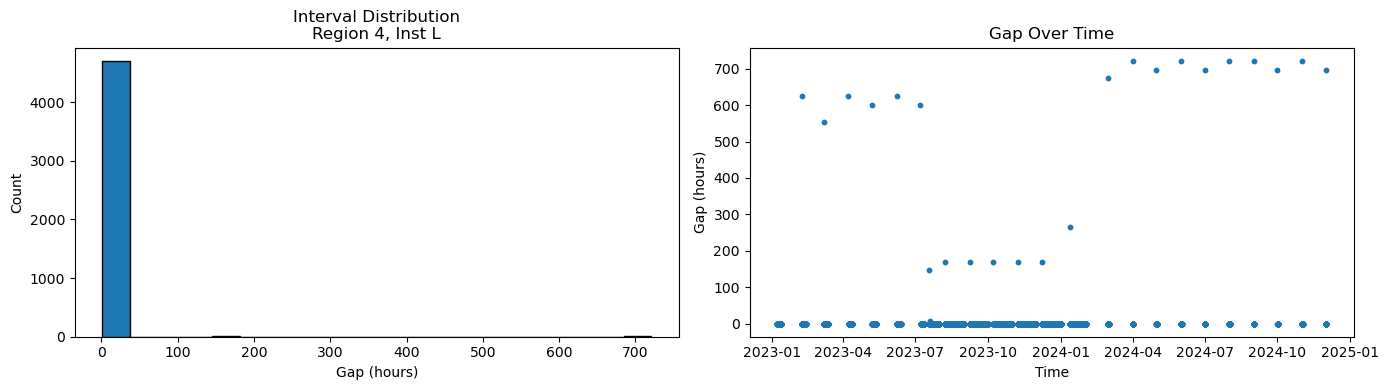

In [5]:
import matplotlib.pyplot as plt

# Loop through each region–instance combo
for (region, inst), grp in df.groupby(['REGION_NUM','INSTANCE_TYPE']):
    # Ensure time ordering
    grp = grp.sort_values('USAGE_HOUR')
    
    # Compute hourly gaps between successive timestamps
    deltas = grp['USAGE_HOUR'].diff().dt.total_seconds() / 3600.0
    
    # Skip if too few points
    if deltas.dropna().empty:
        continue
    
    # Create side‐by‐side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # 1) Histogram of intervals
    axes[0].hist(deltas.dropna(), bins=20, edgecolor='k')
    axes[0].set_title(f"Interval Distribution\nRegion {region}, Inst {inst}")
    axes[0].set_xlabel("Gap (hours)")
    axes[0].set_ylabel("Count")
    
    # 2) Interval over time
    axes[1].scatter(grp['USAGE_HOUR'][1:], deltas[1:], s=10)
    axes[1].set_title("Gap Over Time")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Gap (hours)")
    
    plt.tight_layout()
    plt.show()


In [7]:
import pandas as pd
from dateutil import parser

# 1) Load raw CSV
df = pd.read_csv("hourly_normalized.csv")

# 2) Robust parser for mixed formats
def parse_ts(s):
    s = s.strip()
    # drop trailing “.000” if present
    if s.endswith(".000"):
        s = s[:-4]
    return parser.parse(s, dayfirst=True)

# 3) Apply parsing and sort
df['USAGE_HOUR'] = df['USAGE_HOUR'].apply(parse_ts)
df = df.sort_values('USAGE_HOUR').reset_index(drop=True)

# 4) Analyze each region–instance combo
summary = []
for (region, inst), grp in df.groupby(['REGION_NUM','INSTANCE_TYPE']):
    grp = grp.sort_values('USAGE_HOUR').reset_index(drop=True)
    # compute gap in hours
    grp['delta_hr'] = grp['USAGE_HOUR'].diff().dt.total_seconds().div(3600)
    # assign segment IDs whenever gap ≠ 1 or at first row
    grp['seg_id'] = (grp['delta_hr'] != 1).cumsum()
    # summarize each segment
    segs = (grp
            .groupby('seg_id')
            .agg(
                start=('USAGE_HOUR','first'),
                end  =('USAGE_HOUR','last'),
                length=('USAGE_HOUR','count')
            )
            .reset_index(drop=True))
    # metrics
    total        = len(grp)
    n_segs       = len(segs)
    good_segs    = segs[segs['length']>1]
    n_good_segs  = len(good_segs)
    recs_good    = int(good_segs['length'].sum())
    pct_consist  = recs_good / total * 100
    summary.append({
        'REGION_NUM':        region,
        'INSTANCE_TYPE':     inst,
        'total_records':     total,
        'n_segments':        n_segs,
        'n_consistent_segs': n_good_segs,
        'records_in_consist':recs_good,
        'pct_consistent':    pct_consist
    })
    # Optional: save segment details for manual inspection
    segs.to_csv(f"segments_r{region}_i{inst}.csv", index=False)

# 5) Review the summary
summary_df = pd.DataFrame(summary)
print(summary_df)


    REGION_NUM INSTANCE_TYPE  total_records  n_segments  n_consistent_segs  \
0            1             A          16376          65                 37   
1            1             B          13783          23                 23   
2            1             C           2154         842                419   
3            1             D          11930          24                 24   
4            1             E          13300          24                 24   
5            1             G            508         180                 55   
6            1             H            209         100                 28   
7            1             I          19737          23                 23   
8            1             J           9943          13                 13   
9            1             K           9944          13                 13   
10           1             L           6583          23                 23   
11           2             A          16980          44         